# Preliminary POC

A)	Thématique

Les réseaux de neurones convolutifs (CNN) ont démontré une compétence remarquable pour extraire des caractéristiques complexes des images, ce qui facilite grandement la classification d'images. Cependant, les modèles CNN génériques peuvent ne pas être idéaux pour toutes les tâches, d'où l'importance du fine-tuning, qui ajuste les poids d'un modèle pré-entraîné pour des tâches spécifiques. Cette approche peut améliorer significativement les performances de classification.
Dans le cadre du fine-tuning, les algorithmes d'optimisation jouent un rôle clé. Adam, en particulier, a été largement reconnu pour sa capacité à accélérer la convergence du gradient dans les réseaux de neurones profonds. Cet algorithme, introduit par Diederik P. Kingma et Jimmy Ba dans leur article de 2014 intitulé "Adam : Une Méthode pour l'Optimisation Stochastique.", ajuste le taux d'apprentissage pour chaque poids dans le réseau de manière adaptative, en se basant sur les estimations du premier et du second moment des gradients.
Récemment, des avancées importantes ont été réalisées dans le développement et l'optimisation des algorithmes d'optimisation. Nous allons donc nous concentrer sur le dernier algorithme d'optimisation développé dans l’état de l’art ; nous pouvons notamment citer le dernier en date de mars 2023 : Lion, signifiant EvoLved Sign Momentum.

B)	Prototype à implémenter (Dataset, Baseline, méthode mise en œuvre) 

Nous désirons repartir de notre modèle pré-entraîné Xception du projet 6, qui se servait de l’algorithme d'optimisation Adam avec Tensorflow et Keras, et qui performait à 0.82 sur son score d’accuracy global. Ce sera notre modèle Baseline, que nous reprendrons et que nous modifierons afin d’utiliser l’algorithme d’optimisation Lion (EvoLved Sign Momentum.) 
Nous comparons les scores grâce au score d’accuracy, precision, recall et F1. Nous ferons une visualisation par une matrice de confusion. 
Nous utiliserons le même dataset crée à partir du dataset fournit par le projet 6 : « Classez des images à l'aide d'algorithmes de Deep Learning », soit le « Stanford Dogs Dataset ». Nous utiliserons un dataset d’images prétraités avec un générateur Keras et qui sera fourni avec les livrables.

C) Méthodologie :  
3 Modèles différents, 2 optimisateurs AdamW et Lion, réglages spécifiques époques, LR etc pour POC

## Imports 

In [1]:
# pip install pandas tqdm missingno matplotlib seaborn scikit-learn tensorflow

In [121]:
import os
import time
import tqdm
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import random
import pandas as pd

import missingno as msno
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

import tarfile
import glob
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import tensorflow.keras.preprocessing.image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import save_img, ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

import json

# Source : https://github.com/google/automl/blob/master/lion/lion_tf2.py
# Upload the file, then place it in your current folder
# import the new Lion optimizer algorithm as 'Lion' to use it. 
from lion_tf2 import Lion

print(os.getcwd())
print("Numpy : {}".format(np.__version__))
print("Pandas : {}".format(pd.__version__))
print("Tqdm : {}".format(tqdm.__version__))
print("Missingno Version : {}".format(msno.__version__))
print("Matplotlib Version : {}".format(matplotlib.__version__))
print("Seaborn Version : {}".format(sns.__version__))
print("Scikit-Learn Version : {}".format(sklearn.__version__))
print("tensorflow Version : {}".format(tensorflow.__version__))
print("json : {}".format(json.__version__))

C:\Users\Lemel\OPC-P7
Numpy : 1.23.5
Pandas : 2.0.2
Tqdm : 4.65.0
Missingno Version : 0.5.2
Matplotlib Version : 3.7.1
Seaborn Version : 0.12.2
Scikit-Learn Version : 1.2.2
tensorflow Version : 2.12.0
json : 2.0.9


# Fonctions

In [3]:
def shape(df):
    """
    Analyzes the shape of the dataframe: 1) Open it, give some infos 2) Nan values 3) Seaborn Heatmap
    """

    # Head & tail
    df_combined = pd.concat([df.head(), df.tail()], axis=0)
    display(df_combined)
    print("\nNumber of Rows: ", df.shape[0])
    print("Number of Columns: ", df.shape[1])

    for col in df.columns:
            print("Column {}: {}".format(col, df[col].dtype))

    # Value counts and missing/duplicated data
    if 'type' in df.columns:
        print("\nValue counts of 'type':")
        print(df['type'].value_counts())
    else:
        print("\n'type' column not found in dataframe.")
    print("\nNumber of missing values:")
    print(df.isna().sum())
    print("\nNumber of duplicated rows:")
    print(df.duplicated().sum())

    # Seaborn heatmap
    print("\nSeaborn heatmap:")
    sns.heatmap(df.isnull(), cmap='viridis')
    plt.show()

In [4]:
def load_and_filter_images(breeds, directory):
    """
    Load and filter images based on specified breeds from a given directory.

    Args:
        breeds (list): A list of strings representing the breeds to filter.
        directory (str): The directory path where the breed subdirectories are located.

    Returns:
        list: A list of lists containing breed and corresponding image path pairs.

    """

    data = []
    # Loop over each breed
    for breed in breeds:
        # Get a list of all the images for this breed
        images = os.listdir(os.path.join(directory, breed))
        # Append the breed and the images to the data list
        for image in images:
            # Full path to the image
            image_path = os.path.join(directory, breed, image)
            data.append([breed, image_path])
    return data

In [37]:
def check_class_distribution(generator):
    # Create a reverse mapping from class indices to breed names
    reverse_class_indices = {v: k for k, v in generator.class_indices.items()}
    class_counts = {}

    for i in range(len(generator)):
        _, labels = generator.next()
        breed_names = [reverse_class_indices[np.argmax(label)] for label in labels]
        for breed in breed_names:
            class_counts[breed] = class_counts.get(breed, 0) + 1

    print(class_counts)

In [38]:
def save_preprocessed_images(generator, set_name):
    # Create a reverse mapping from class indices to breed names
    reverse_class_indices = {v: k for k, v in generator.class_indices.items()}

    for i in range(len(generator)):
        # Get a batch of images
        batch, labels = generator.next()
        # Get the class names of the current batch
        breed_names = [reverse_class_indices[np.argmax(label)] for label in labels]

        for j, (img, breed) in enumerate(zip(batch, breed_names)):
            # Create a directory for the breed if it doesn't exist
            breed_dir = os.path.join(processed_data_path, set_name, breed)
            try:
                os.makedirs(breed_dir, exist_ok=True)
            except Exception as e:
                print(f"Error creating directory {breed_dir}: {e}")
                continue

            # Save the image
            img_path = os.path.join(breed_dir, f"{set_name}_{i}_{j}.jpg")
            try:
                save_img(img_path, img)
            except Exception as e:
                print(f"Error saving image {img_path}: {e}")

In [122]:
# Fonctions pour simplication modèles à suivre.

# Ouverture du dataset

In [5]:
# Data acces

path = "C:\\Users\\Lemel\\OPC-P7"
tar_path = "C:\\Users\\Lemel\\OPC-P7\\images.tar"
extract_path = "C:\\Users\\Lemel\\OPC-P7\\images"

# tarfile.open() to open the file
with tarfile.open(tar_path) as tar:
    # extract the contents of the tar file
    tar.extractall(path=extract_path)
    # Get the list of files in the tar file
    files = tar.getnames()

# Print the number of files
print("Number of files:", len(files))

Number of files: 20701


In [6]:
# Data acces
images_dir = os.path.join(extract_path, "Images")

# Get a list of all the breed directories
breeds = os.listdir(images_dir)

# Initialize a list 
data = []

# Loop over each breed
for breed in breeds:
    # Get a list of all the images for this breed
    images = os.listdir(os.path.join(images_dir, breed))
    # Append the breed and the number of images to the data list
    data.append([breed, len(images)])

# Convert the data list to a DataFrame
df = pd.DataFrame(data, columns=['Breed', 'Number of Images'])

# Print the total number of breeds
print("Total number of breeds:", len(breeds))

Total number of breeds: 120


In [7]:
# Représentartion rapide
df.head()

,Breed,Number of Images
0,n02085620-Chihuahua,152
1,n02085782-Japanese_spaniel,185
2,n02085936-Maltese_dog,252
3,n02086079-Pekinese,149
4,n02086240-Shih-Tzu,214


,Breed,Number of Images
0,n02085620-Chihuahua,152
1,n02085782-Japanese_spaniel,185
2,n02085936-Maltese_dog,252
3,n02086079-Pekinese,149
4,n02086240-Shih-Tzu,214
115,n02113799-standard_poodle,159
116,n02113978-Mexican_hairless,155
117,n02115641-dingo,156
118,n02115913-dhole,150
119,n02116738-African_hunting_dog,169



Number of Rows:  120
Number of Columns:  2
Column Breed: object
Column Number of Images: int64

'type' column not found in dataframe.

Number of missing values:
Breed               0
Number of Images    0
dtype: int64

Number of duplicated rows:
0

Seaborn heatmap:


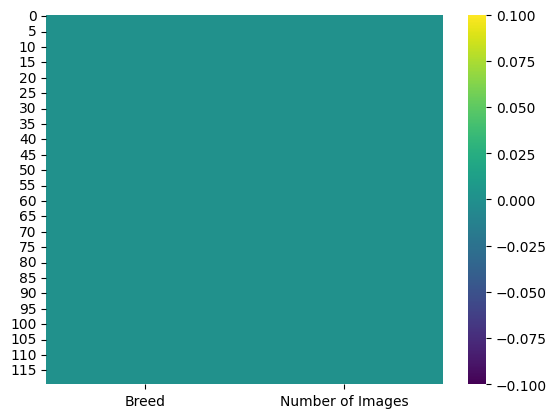

In [8]:
# Ici nous avons la liste de toutes les races 
shape(df)

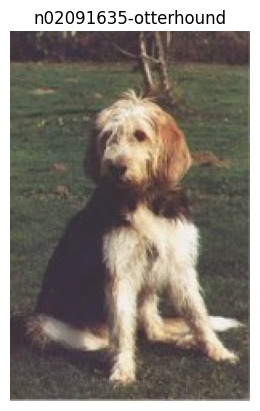

In [9]:
# Random example ; each time.
random_breed = random.choice(breeds)

# Get a list of all images for this 'breed example'
images = os.listdir(os.path.join(images_dir, random_breed))

# Choose a random image from this 'breed example'
random_image = random.choice(images)

# Create the full path to the image example
example_image_path = os.path.join(images_dir, random_breed, random_image)

# Load the image
img = mpimg.imread(example_image_path)

# Display the image
plt.imshow(img)
plt.title(random_breed)
plt.axis('off')  # to hide the axis
plt.show()

# Filtrage du dataset Standford: les 15 races les plus communes 

In [10]:
# Sort the DataFrame by 'Number of Images' in descending order and take the first 15 rows
top_breeds_df = df.sort_values('Number of Images', ascending=False).head(120)

# Get the breed names as a list
top_breeds = top_breeds_df['Breed'].tolist()

print(top_breeds)

['n02085936-Maltese_dog', 'n02088094-Afghan_hound', 'n02092002-Scottish_deerhound', 'n02112018-Pomeranian', 'n02107683-Bernese_mountain_dog', 'n02111889-Samoyed', 'n02090721-Irish_wolfhound', 'n02086240-Shih-Tzu', 'n02111500-Great_Pyrenees', 'n02111129-Leonberg', 'n02110806-basenji', 'n02097474-Tibetan_terrier', 'n02095889-Sealyham_terrier', 'n02108000-EntleBucher', 'n02096051-Airedale', 'n02110958-pug', 'n02091831-Saluki', 'n02096177-cairn', 'n02095570-Lakeland_terrier', 'n02096294-Australian_terrier', 'n02086910-papillon', 'n02112137-chow', 'n02091467-Norwegian_elkhound', 'n02088364-beagle', 'n02111277-Newfoundland', 'n02110185-Siberian_husky', 'n02091244-Ibizan_hound', 'n02086646-Blenheim_spaniel', 'n02091134-whippet', 'n02088466-bloodhound', 'n02098413-Lhasa', 'n02094258-Norwich_terrier', 'n02085782-Japanese_spaniel', 'n02107312-miniature_pinscher', 'n02097658-silky_terrier', 'n02091032-Italian_greyhound', 'n02093647-Bedlington_terrier', 'n02096585-Boston_bull', 'n02113023-Pembroke

In [11]:
# Sort the DataFrame by 'Number of Images' in descending order and take the first 15 rows
top_breeds_df = df.sort_values('Number of Images', ascending=False).head(15)

# Get the breed names as a list
top_breeds = top_breeds_df['Breed'].tolist()

print(top_breeds)

['n02085936-Maltese_dog', 'n02088094-Afghan_hound', 'n02092002-Scottish_deerhound', 'n02112018-Pomeranian', 'n02107683-Bernese_mountain_dog', 'n02111889-Samoyed', 'n02090721-Irish_wolfhound', 'n02086240-Shih-Tzu', 'n02111500-Great_Pyrenees', 'n02111129-Leonberg', 'n02110806-basenji', 'n02097474-Tibetan_terrier', 'n02095889-Sealyham_terrier', 'n02108000-EntleBucher', 'n02096051-Airedale']


In [12]:
top_breeds_df.head(n=15)

,Breed,Number of Images
2,n02085936-Maltese_dog,252
9,n02088094-Afghan_hound,239
26,n02092002-Scottish_deerhound,232
107,n02112018-Pomeranian,219
88,n02107683-Bernese_mountain_dog,218
106,n02111889-Samoyed,218
19,n02090721-Irish_wolfhound,218
4,n02086240-Shih-Tzu,214
105,n02111500-Great_Pyrenees,213
103,n02111129-Leonberg,210


In [13]:
# Use the function load_and_filter_images
data = load_and_filter_images(top_breeds, images_dir)

# Convert the data list to a DataFrame
filtered_df = pd.DataFrame(data, columns=['Breed', 'Image'])

In [14]:
filtered_df.nunique()

Breed      15
Image    3254
dtype: int64

# Pictures Pre-processing 

**OPC : Dans un premier temps de pré-processer des images avec des techniques spécifiques (e.g. whitening, equalization, éventuellement modification de la taille des images) et de réaliser de la data augmentation (mirroring, cropping...).**

*Dans un deuxième temps, nous sauvegardons les images dans un nouveau répertoire pour une utilisation ultérieure avec un CNN* 

## ImageDataGenerator

**Preprocessing of images with specific techniques:** 

Whitening: This is done with ImageDataGenerator by setting the zca_whitening parameter to True. ZCA Whitening is a technique used to reduce the redundancy in the matrix of pixel images, and it helps in highlighting the structure and features of the images.

Resizing: The target_size parameter of the flow_from_directory method is used to resize all the images to a consistent size (in our case, we choose 180x180 pixels).

Normalization: This is done by setting the rescale parameter to 1./255 in ImageDataGenerator. Values range : [0, 1].

*Equalization:  Image equalization is usually used to improve the contrast of the image. Keras' ImageDataGenerator doesn't offer this function out of the box. This operation can be implemented with OpenCV.*

**Data Augmentation:**

Mirroring: set horizontal_flip to True in ImageDataGenerator.

Rotation, Zooming, and Shifting: set rotation_range, zoom_range, width_shift_range, and height_shift_range in ImageDataGenerator. *It's not really useful in our case*

*Cropping: Unfortunately, this is not included in the ImageDataGenerator function of Keras. ! cropping might cut off important parts of the dog!

In [21]:
# Count the number of images per breed
image_counts = filtered_df['Breed'].value_counts()

# Print the counts
print(image_counts)

Breed
n02085936-Maltese_dog             252
n02088094-Afghan_hound            239
n02092002-Scottish_deerhound      232
n02112018-Pomeranian              219
n02107683-Bernese_mountain_dog    218
n02111889-Samoyed                 218
n02090721-Irish_wolfhound         218
n02086240-Shih-Tzu                214
n02111500-Great_Pyrenees          213
n02111129-Leonberg                210
n02110806-basenji                 209
n02097474-Tibetan_terrier         206
n02095889-Sealyham_terrier        202
n02108000-EntleBucher             202
n02096051-Airedale                202
Name: count, dtype: int64


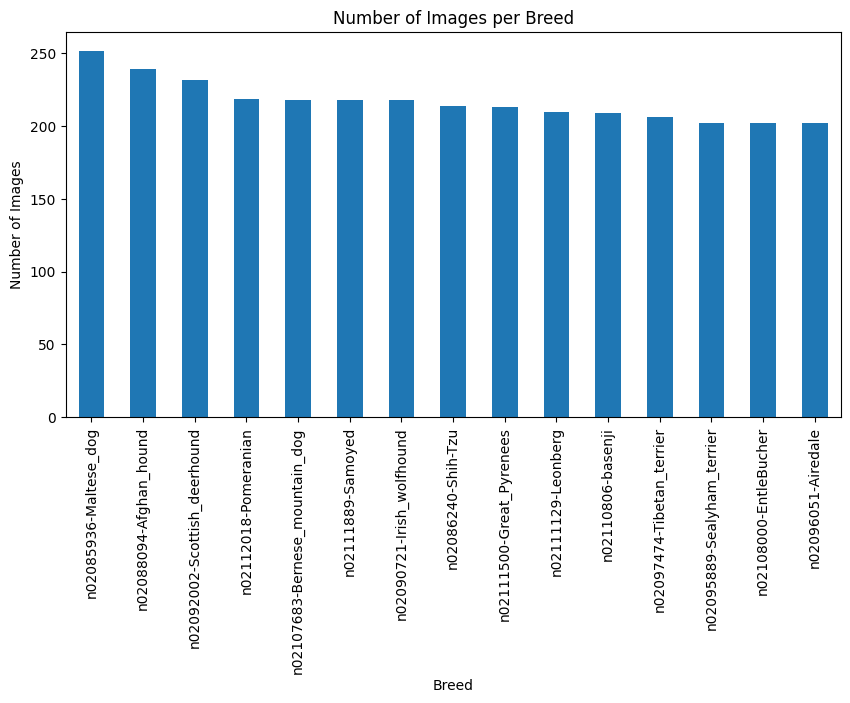

In [23]:
# Checking class imbalance
# Plot the image counts
image_counts.plot(kind='bar', figsize=(10, 5))
plt.title('Number of Images per Breed')
plt.xlabel('Breed')
plt.ylabel('Number of Images')
plt.show()

## Démonstration avant/après

Preprocessing is an essential step in any machine learning, preprocessing can range from simple rescaling of pixel values to complex transformations such as rotations and translations. Preprocessing serves two primary purposes: (i) to make the data compatible with machine learning model, and (ii) to improve model generalization.

Rescaling
The rescaling operation (rescale=1./255) is performed to transform the pixel values from their original range (0 to 255) to a standardized range (0 to 1), most machine learning models perform better on standardized data. It helps the model converge faster during training and prevents it from getting stuck in local minima.

ZCA Whitening
ZCA Whitening is a method that linearly transforms the image such that the covariance of the image data is the identity matrix. It's used to highlight the edges and other high-frequency components in the image, helping the model extract relevant features.

Data Augmentation
The rest of the operations (rotation, zoom, shift, flip) can serve to augment the dataset. Data augmentation is a strategy that allows us to significantly increase the diversity of data available for training models, without actually collecting new data. 

Visualizing the original and preprocessed images side by side can be a useful practice. This can help us tuning the model.

In [18]:
# Les images ne sont pas toutes à la même taille!
batch_size = 32
img_height = 180
img_width = 180

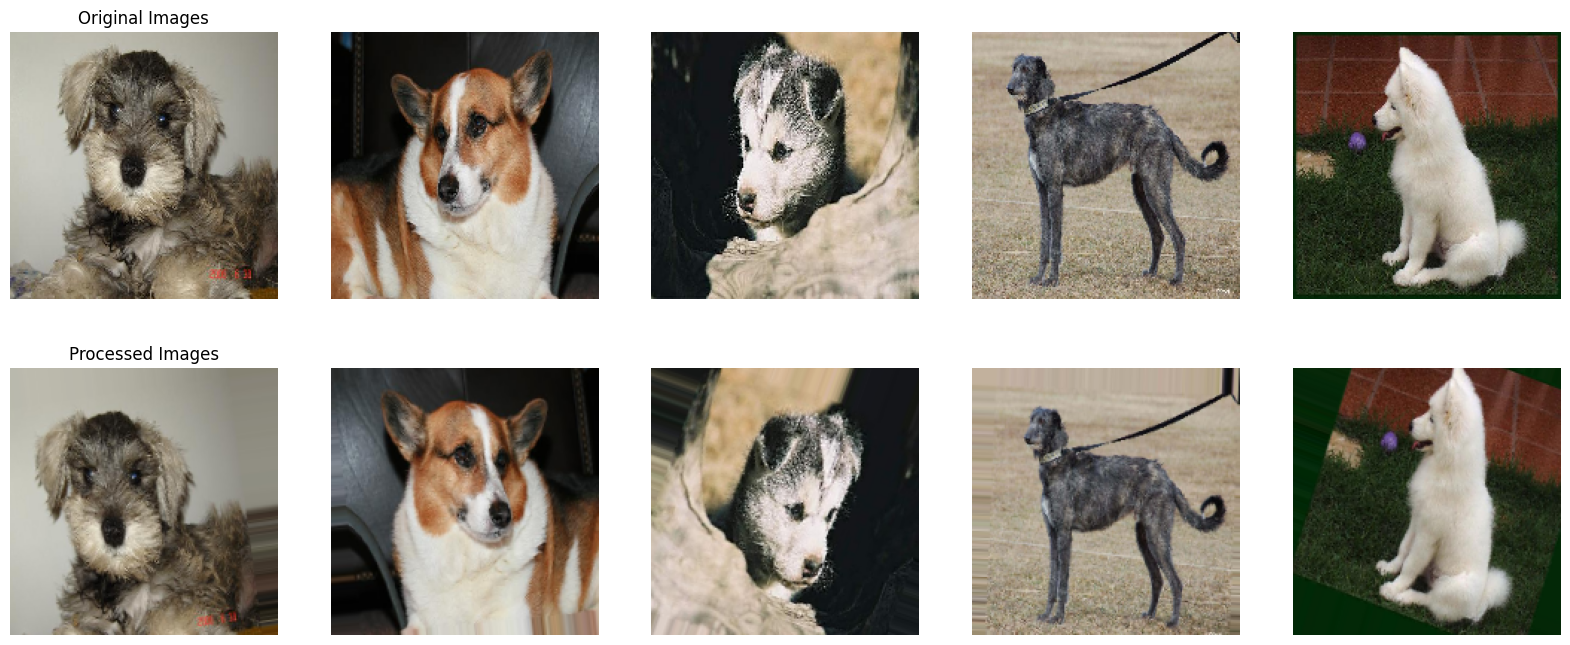

In [19]:
# root directory where the images are
root_dir = "C:\\Users\\Lemel\\OPC-P7\\images"

all_images = []
for subdir, dirs, files in os.walk(root_dir):
    for file in files:
        # ensure the file is an jpg or png image. 
        if file.endswith('.jpg') or file.endswith('.png'):  
            all_images.append(os.path.join(subdir, file))

# Now select 5 random images
num_images_to_sample = min(5, len(all_images))

random_images = random.sample(all_images, num_images_to_sample)

# Initialize the ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,  # normalize pixel values
    zca_whitening=True,  # apply ZCA whitening
    rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True  # randomly flip images horizontally
)

# Load, preprocess, and display the images
plt.figure(figsize=(20, 8))

for i, img_path in enumerate(random_images):
    # Load and display original images
    img = image.load_img(img_path, target_size=(img_height, img_width))
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    if i == 0:
        plt.title('Original Images')

    # Preprocess and display processed images
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_processed = datagen.standardize(img_array)
    img_transformed = datagen.random_transform(img_processed[0])
    plt.subplot(2, 5, i+6)  # Display the processed images on the second row
    plt.imshow(img_transformed)
    plt.axis('off')
    if i == 0:
        plt.title('Processed Images')

plt.show()

### Train test split stratified


- We want to build a model that can generalize well to unseen data. By reserving a portion of the data for validation, we're helping ensure that our model isn't simply memorizing the training data, but is learning patterns that can generalize to new data. That is the goal of preprocessing and why i did that choice, knowing that ImageDataGenerator is doing ramdonly the transformation on the picture on the original dataset then saved it into the new dataset i made.  
- The ImageDataGenerator instance datagen is used for both training and validation sets, and it includes various transformations such as ZCA whitening, rotation, zoom, width and height shifts, and horizontal flipping.
On the other hand, the test set images are only rescaled. The ImageDataGenerator instance test_datagen, which is used for the test set, only includes the rescaling transformation. This difference was intended to demonstrate a common practice: applying data augmentation to training and validation sets for better model generalization, while keeping the test set in its original form for a more realistic evaluation.

#### Train test split + Image data Generator ; test size 20% 
I want to split your dataset into three distinct parts: training, validation, and testing, so i first split the total dataset into a training set and a temporary set. Then, i split the temporary set into validation and testing sets.

In [25]:
SEED = 42

In [33]:
# Split the data into training and a temporary set using an 80/20 split
train_df, temp_df = train_test_split(filtered_df, stratify=filtered_df['Breed'], test_size=0.2, random_state= SEED)

# Split the temporary set into validation and test sets using a 50/50 split
val_df, test_df = train_test_split(temp_df, stratify=temp_df['Breed'], test_size=0.5, random_state= SEED)

In [34]:
# Set the directory where the images are
images_dir = os.path.join(extract_path, "Images")

# Define directory
directory = images_dir

In [35]:
# Initialize the ImageDataGenerator with augmentations for training and validation sets
datagen = ImageDataGenerator(
    rescale=1./255,  # normalize pixel values
    zca_whitening=True,  # apply ZCA whitening
    rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    validation_split=0.2  # use 20% of the data for validation
)

# Use flow_from_dataframe method for training set
train_it = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=directory,
    x_col="Image",
    y_col="Breed",
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    subset='training'  # training data
)

# Use flow_from_dataframe method for validation set
val_it = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=directory,
    x_col="Image",
    y_col="Breed",
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    subset='validation'  # validation data
)

# Initialize the ImageDataGenerator without augmentations for test set
test_datagen = ImageDataGenerator(rescale=1./255)  # normalize pixel values only

# Use flow_from_dataframe method for test set
test_it = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=directory,
    x_col="Image",
    y_col="Breed",
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False  # no shuffling for test set
)

Found 2083 validated image filenames belonging to 15 classes.
Found 520 validated image filenames belonging to 15 classes.
Found 326 validated image filenames belonging to 15 classes.


In [39]:
check_class_distribution(train_it)
check_class_distribution(val_it)
check_class_distribution(test_it)

{'n02111889-Samoyed': 134, 'n02095889-Sealyham_terrier': 126, 'n02097474-Tibetan_terrier': 132, 'n02111129-Leonberg': 134, 'n02092002-Scottish_deerhound': 149, 'n02108000-EntleBucher': 136, 'n02110806-basenji': 138, 'n02107683-Bernese_mountain_dog': 140, 'n02088094-Afghan_hound': 152, 'n02085936-Maltese_dog': 157, 'n02112018-Pomeranian': 142, 'n02086240-Shih-Tzu': 142, 'n02090721-Irish_wolfhound': 139, 'n02111500-Great_Pyrenees': 136, 'n02096051-Airedale': 126}
{'n02092002-Scottish_deerhound': 37, 'n02112018-Pomeranian': 33, 'n02096051-Airedale': 36, 'n02111889-Samoyed': 40, 'n02085936-Maltese_dog': 45, 'n02111500-Great_Pyrenees': 34, 'n02107683-Bernese_mountain_dog': 34, 'n02111129-Leonberg': 34, 'n02110806-basenji': 29, 'n02095889-Sealyham_terrier': 36, 'n02088094-Afghan_hound': 39, 'n02086240-Shih-Tzu': 29, 'n02090721-Irish_wolfhound': 35, 'n02108000-EntleBucher': 26, 'n02097474-Tibetan_terrier': 33}
{'n02085936-Maltese_dog': 25, 'n02111500-Great_Pyrenees': 22, 'n02111129-Leonberg':

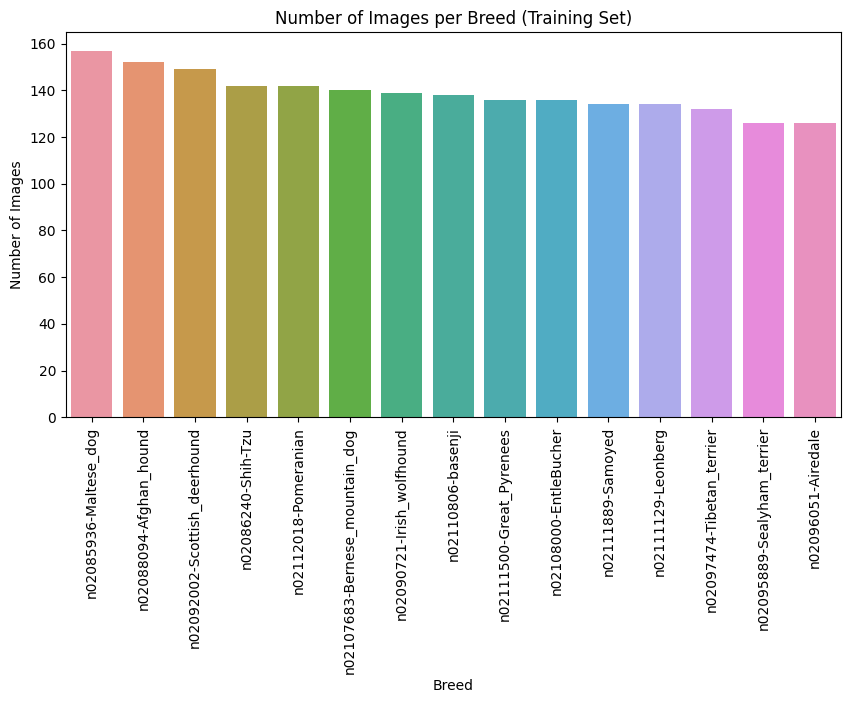

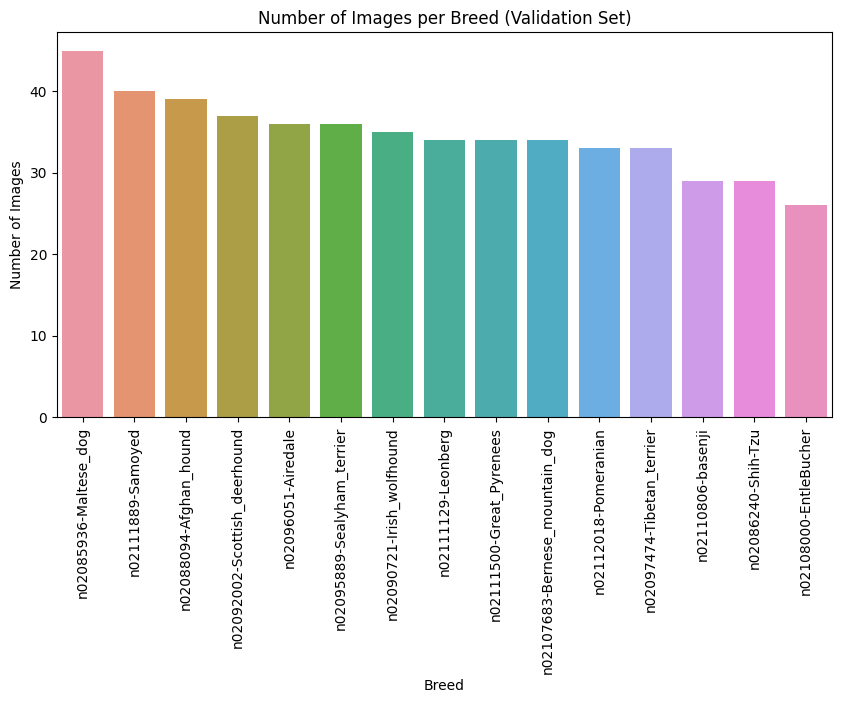

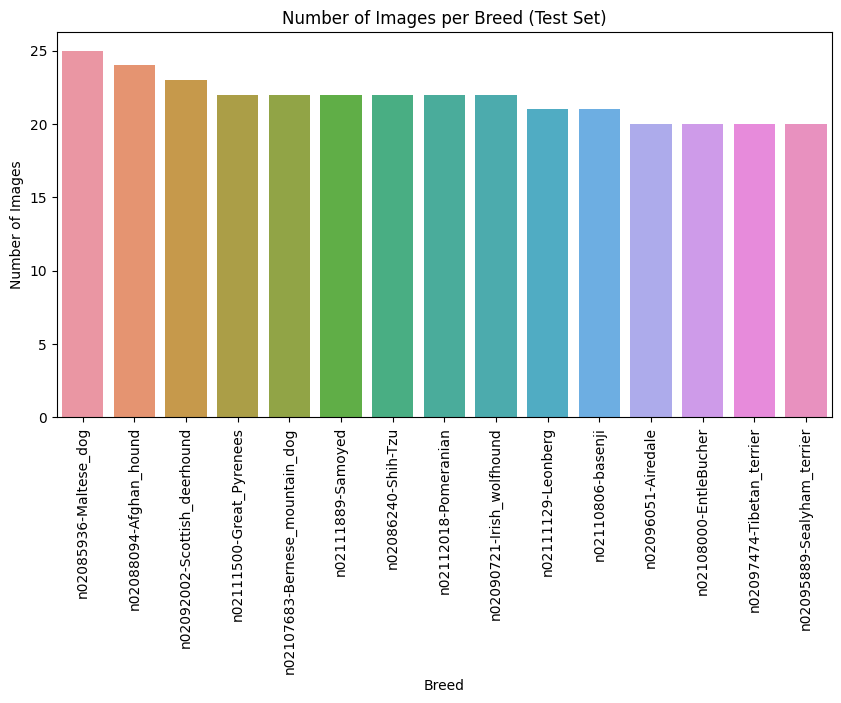

In [36]:
# Initialize a dictionary for each set
image_counts_train_it = {}
image_counts_val_it = {}
image_counts_test_it = {}

# Count the number of images per breed in each set
datasets = [(train_it, image_counts_train_it), (val_it, image_counts_val_it), (test_it, image_counts_test_it)]
for dataset, counts_dict in datasets:
    for i in range(len(dataset.filenames)):
        breed = dataset.filenames[i].split('\\')[-2]
        if breed in counts_dict:
            counts_dict[breed] += 1
        else:
            counts_dict[breed] = 1

# Create DataFrames for image counts
image_counts_train_it_df = pd.DataFrame({'Breed': list(image_counts_train_it.keys()), 'Count': list(image_counts_train_it.values())})
image_counts_val_it_df = pd.DataFrame({'Breed': list(image_counts_val_it.keys()), 'Count': list(image_counts_val_it.values())})
image_counts_test_it_df = pd.DataFrame({'Breed': list(image_counts_test_it.keys()), 'Count': list(image_counts_test_it.values())})

# Sort the DataFrames by breed count
image_counts_train_it_df = image_counts_train_it_df.sort_values('Count', ascending=False)
image_counts_val_it_df = image_counts_val_it_df.sort_values('Count', ascending=False)
image_counts_test_it_df = image_counts_test_it_df.sort_values('Count', ascending=False)

# Plot the image counts for each set
for df, title in [(image_counts_train_it_df, 'Training Set'), (image_counts_val_it_df, 'Validation Set'), (image_counts_test_it_df, 'Test Set')]:
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Breed', y='Count', data=df)
    plt.title(f'Number of Images per Breed ({title})')
    plt.xlabel('Breed')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=90)
    plt.show()


## Sauvegarde des images pré-traitées

In [40]:
# Define the path to the directory where the preprocessed images will be saved
processed_data_path = "C:\\Users\\Lemel\\OPC-P7\\ProcessedImages"

In [41]:
# Save the training and validation images
save_preprocessed_images(train_it, "train")
save_preprocessed_images(val_it, "val")
save_preprocessed_images(test_it, "test")

# Xception baseline model with Adam optimiser (Before ADAM-W & LION optimiser)
Source : https://www.tensorflow.org/tutorials/generative/style_transfer?hl=fr 
https://www.kaggle.com/code/michaelfumery/computer-vision-cnn-stanford-dogs-dataset
  
  **We have choosen the Xception model car il demande  moins de ressources**

In [113]:
available_optimizers = dir(optimizers)
optimizer_list = [optimizer for optimizer in available_optimizers if not optimizer.startswith('_')]

print(optimizer_list)

['Adadelta', 'Adafactor', 'Adagrad', 'Adam', 'AdamW', 'Adamax', 'Ftrl', 'Nadam', 'Optimizer', 'RMSprop', 'SGD', 'deserialize', 'experimental', 'get', 'legacy', 'schedules', 'serialize']


## Adam Baseline model optimiser : lr = 0.001 & batch_size = 32

In [80]:
img_height = 180
img_width = 180
num_channels = 3  # For RGB images

In [81]:
# Load the pre-trained Xception model without the top (classification) layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, num_channels))

In [82]:
# Define directories : # Replace with your cd here when you upload this notebook
train_dir = 'C:\\Users\\Lemel\\OPC-P7\\ProcessedImages\\train'
val_dir = 'C:\\Users\\Lemel\\OPC-P7\\ProcessedImages\\val'
test_dir = 'C:\\Users\\Lemel\\OPC-P7\\ProcessedImages\\test'  

# Initialize the ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)  # normalize pixel values

# Set batch size as per your requirement
batch_size = 32

# Load images from directories
train_generator = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,
)

validation_generator = datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,
)

# Load images from test directory
test_generator = datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,
)

Found 2083 images belonging to 15 classes.
Found 520 images belonging to 15 classes.
Found 326 images belonging to 15 classes.


In [83]:
# Define constants
num_classes = 15  # numbers of breeds here
num_breeds = num_classes  #  num_breeds and num_classes are same

In [84]:
# Define pretrained Xception model
xception_model = tf.keras.applications.xception.Xception(
    weights='imagenet',
    include_top=False, 
    pooling='avg',
    input_shape=(img_height, img_width, num_channels)
)

In [85]:
# Freeze layers of pretrained model
for layer in xception_model.layers:
    layer.trainable = False

In [86]:
# Define new layers
base_output = xception_model.output
base_output = Dense(128, activation='relu')(base_output)
base_output = Dropout(0.2)(base_output)
predictions = Dense(num_breeds, activation='softmax')(base_output)

In [87]:
# Define new model
my_xcept_model = Model(inputs=xception_model.input, outputs=predictions)

# The default learning rate for Adam in Keras is 0.001, and we keep it that way for the moment as our baseline model. 
my_xcept_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Define EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)  # adjust patience for 20

In [90]:
# Start timing
start_time = time.time()

# Train the model
history_xcept = my_xcept_model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=len(train_generator) / 32,
    epochs=100,
    verbose=2,
    callbacks=[early_stop] 
)

# End timing and print total training time
end_time = time.time()
total_time = end_time - start_time
print(f"Total training time: {total_time} seconds")

Epoch 1/100
2/2 - 12s - loss: 1.4808 - accuracy: 0.5938 - val_loss: 1.5745 - val_accuracy: 0.5442 - 12s/epoch - 6s/step
Epoch 2/100
2/2 - 12s - loss: 0.5453 - accuracy: 0.9375 - val_loss: 1.6691 - val_accuracy: 0.4904 - 12s/epoch - 6s/step
Epoch 3/100
2/2 - 12s - loss: 2.2444 - accuracy: 0.4479 - val_loss: 1.5840 - val_accuracy: 0.4981 - 12s/epoch - 6s/step
Epoch 4/100
2/2 - 12s - loss: 1.3138 - accuracy: 0.6562 - val_loss: 1.3976 - val_accuracy: 0.5673 - 12s/epoch - 6s/step
Epoch 5/100
2/2 - 13s - loss: 1.4944 - accuracy: 0.5938 - val_loss: 1.4074 - val_accuracy: 0.5712 - 13s/epoch - 6s/step
Epoch 6/100
2/2 - 13s - loss: 0.9727 - accuracy: 0.6875 - val_loss: 1.3959 - val_accuracy: 0.5385 - 13s/epoch - 6s/step
Epoch 7/100
2/2 - 13s - loss: 0.8457 - accuracy: 0.8333 - val_loss: 1.3684 - val_accuracy: 0.5615 - 13s/epoch - 6s/step
Epoch 8/100
2/2 - 13s - loss: 1.6933 - accuracy: 0.4479 - val_loss: 1.2950 - val_accuracy: 0.5846 - 13s/epoch - 6s/step
Epoch 9/100
2/2 - 12s - loss: 2.1261 - a

In [91]:
# Score sur la validation dataset
score_my_xcept_model = my_xcept_model.evaluate(validation_generator)

17/17 [==============================] - 10s 582ms/step - loss: 0.6265 - accuracy: 0.7923


In [92]:
# Score sur le test dataset
score_my_xcept_model_test = my_xcept_model.evaluate(test_generator)

11/11 [==============================] - 6s 562ms/step - loss: 0.5930 - accuracy: 0.8160


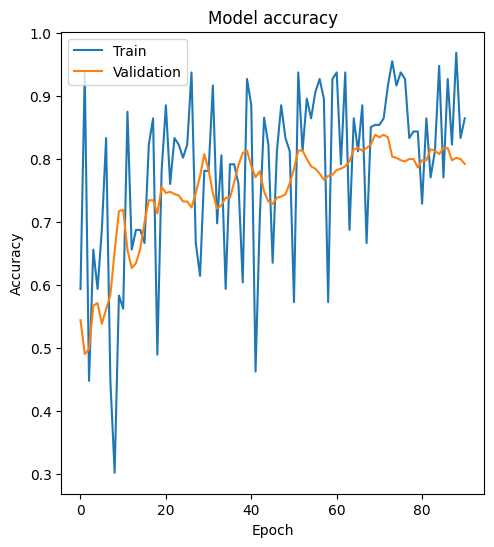

In [93]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_xcept.history['accuracy'])
plt.plot(history_xcept.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

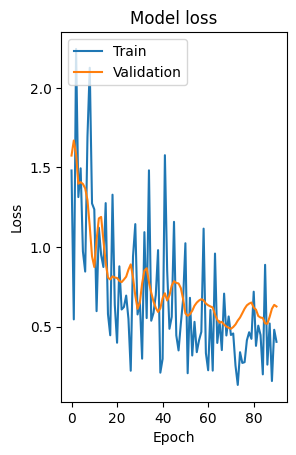

In [94]:
# Plot training & validation loss values

plt.subplot(1, 2, 2)
plt.plot(history_xcept.history['loss'])
plt.plot(history_xcept.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [95]:
# Predict classes with my validation dataset
y_pred = my_xcept_model.predict(validation_generator)
y_pred_classes = y_pred.argmax(axis=-1)

17/17 [==============================] - 10s 580ms/step


Found 520 images belonging to 15 classes.
5/5 [==============================] - 9s 2s/step
                                precision    recall  f1-score   support

         n02085936-Maltese_dog       0.84      0.71      0.77        45
            n02086240-Shih-Tzu       0.67      0.76      0.71        29
        n02088094-Afghan_hound       0.85      0.74      0.79        39
     n02090721-Irish_wolfhound       1.00      0.20      0.33        35
  n02092002-Scottish_deerhound       0.73      0.95      0.82        37
    n02095889-Sealyham_terrier       0.84      0.86      0.85        36
            n02096051-Airedale       0.89      0.94      0.92        36
     n02097474-Tibetan_terrier       0.93      0.79      0.85        33
n02107683-Bernese_mountain_dog       0.97      0.82      0.89        34
         n02108000-EntleBucher       0.86      0.96      0.91        26
             n02110806-basenji       0.93      0.93      0.93        29
            n02111129-Leonberg       0.65  

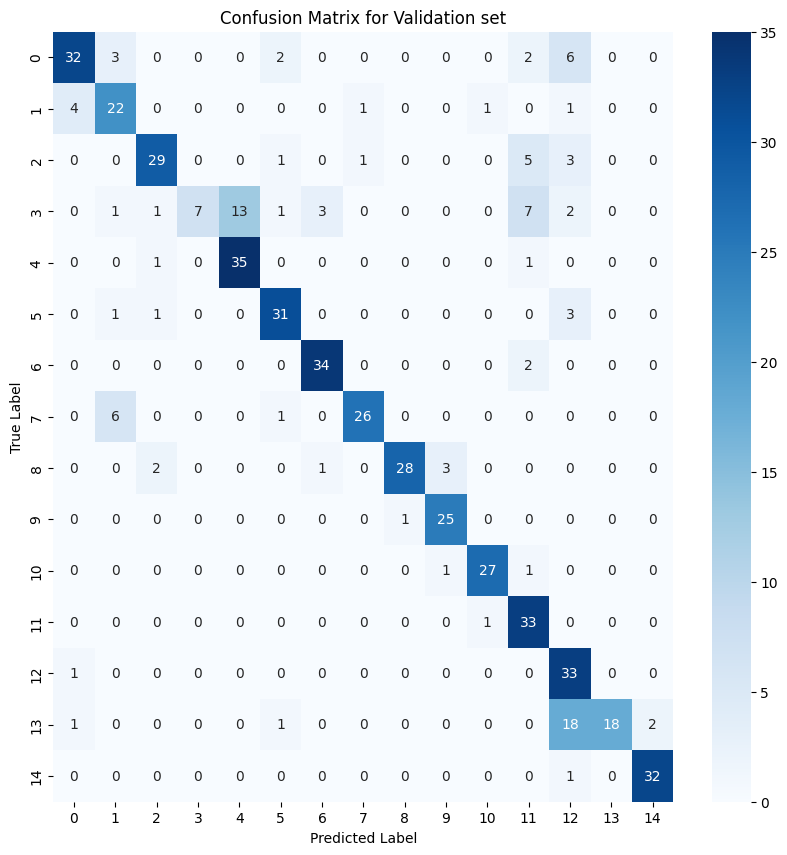

In [96]:
# Recreate the validation generator with shuffle = False

validation_generator = datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,  # Important for correct class labels
)

# Get the true class labels
y_true = validation_generator.classes

# Predict the classes
predictions = my_xcept_model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)

# Get the class indices
class_indices = validation_generator.class_indices

# Create an inverse mapping from index to class name
index_to_class = {v: k for k, v in class_indices.items()}

# Convert true and predicted classes to their respective names
y_true_names = np.vectorize(index_to_class.get)(y_true)
y_pred_names = np.vectorize(index_to_class.get)(y_pred)

# Generate the confusion matrix
cm = confusion_matrix(y_true_names, y_pred_names, labels=list(class_indices.keys()))

# Display the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Validation set')

# Display the classification report
print(classification_report(y_true_names, y_pred_names, target_names=list(class_indices.keys())))


In [99]:
# Predict classes with my validation dataset
predictions_test = my_xcept_model.predict(test_generator)
y_pred_test = np.argmax(predictions_test, axis=1)

3/3 [==============================] - 6s 2s/step


Found 326 images belonging to 15 classes.
                                precision    recall  f1-score   support

         n02085936-Maltese_dog       0.77      0.92      0.84        25
            n02086240-Shih-Tzu       0.83      0.68      0.75        22
        n02088094-Afghan_hound       0.96      0.96      0.96        24
     n02090721-Irish_wolfhound       0.88      0.32      0.47        22
  n02092002-Scottish_deerhound       0.66      0.83      0.73        23
    n02095889-Sealyham_terrier       0.86      0.95      0.90        20
            n02096051-Airedale       0.90      0.95      0.93        20
     n02097474-Tibetan_terrier       0.82      0.70      0.76        20
n02107683-Bernese_mountain_dog       0.90      0.82      0.86        22
         n02108000-EntleBucher       0.83      0.95      0.88        20
             n02110806-basenji       0.91      0.95      0.93        21
            n02111129-Leonberg       0.66      1.00      0.79        21
      n02111500-Great

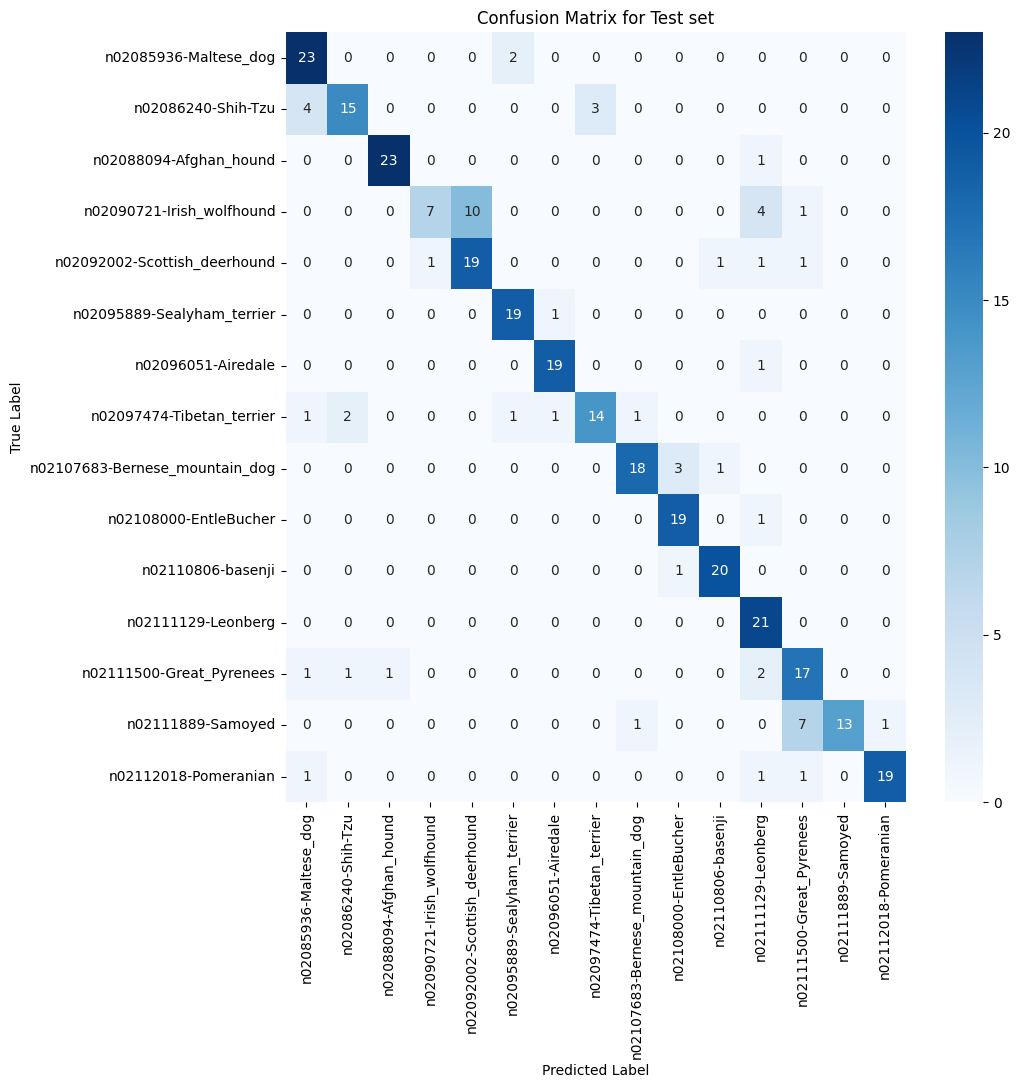

In [100]:
test_generator = datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,  # Important for correct class labels
)

# Get the true class labels
y_true_test = test_generator.classes

# Get breed names
breed_names = list(test_generator.class_indices.keys())

# Create a dictionary to convert class labels to breed names
class_to_breed = {v: k for k, v in test_generator.class_indices.items()}

# Convert class labels to breed names
y_true_test_breeds = [class_to_breed[label] for label in y_true_test]
y_pred_test_breeds = [class_to_breed[label] for label in y_pred_test]

# Generate the confusion matrix
cm_test = confusion_matrix(y_true_test_breeds, y_pred_test_breeds, labels=breed_names)

# Display the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.xticks(ticks=np.arange(len(breed_names)) + 0.5, labels=breed_names, rotation=90)
plt.yticks(ticks=np.arange(len(breed_names)) + 0.5, labels=breed_names, rotation=0)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test set')

# Display the classification report
print(classification_report(y_true_test_breeds, y_pred_test_breeds, target_names=breed_names))


### Sauvegarde du modèle et des indices de classes

In [102]:
# Save the model
my_xcept_model.save('xcept_baselineAdam.lr0.001')

# Save the class_indices
with open('class_indices.json', 'w') as f:
    json.dump(train_generator.class_indices, f)

INFO:tensorflow:Assets written to: xcept_baselineAdam.lr0.001\assets


INFO:tensorflow:Assets written to: xcept_baselineAdam.lr0.001\assets


## Adam Baseline model optimiser : lr = 0.0001 & batch_size = 32

In [123]:
img_height = 180
img_width = 180
num_channels = 3  # For RGB images

In [124]:
# Load the pre-trained Xception model without the top (classification) layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, num_channels))

In [125]:
# Define directories : # Replace with your cd here when you upload this notebook
train_dir = 'C:\\Users\\Lemel\\OPC-P7\\ProcessedImages\\train'
val_dir = 'C:\\Users\\Lemel\\OPC-P7\\ProcessedImages\\val'
test_dir = 'C:\\Users\\Lemel\\OPC-P7\\ProcessedImages\\test'  

# Initialize the ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)  # normalize pixel values

# Set batch size as per your requirement
batch_size = 32

# Load images from directories
train_generator = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,
)

validation_generator = datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,
)

# Load images from test directory
test_generator = datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,
)

Found 2083 images belonging to 15 classes.
Found 520 images belonging to 15 classes.
Found 326 images belonging to 15 classes.


In [126]:
# Define constants
num_classes = 15  # numbers of breeds here
num_breeds = num_classes  #  num_breeds and num_classes are same

In [127]:
# Define pretrained Xception model
xception_model = tf.keras.applications.xception.Xception(
    weights='imagenet',
    include_top=False, 
    pooling='avg',
    input_shape=(img_height, img_width, num_channels)
)

In [128]:
# Freeze layers of pretrained model
for layer in xception_model.layers:
    layer.trainable = False

In [129]:
# Define new layers
base_output = xception_model.output
base_output = Dense(128, activation='relu')(base_output)
base_output = Dropout(0.2)(base_output)
predictions = Dense(num_breeds, activation='softmax')(base_output)

In [130]:
# Define new model
my_xcept_model = Model(inputs=xception_model.input, outputs=predictions)

# Define Adam optimizer with a learning rate of 0.0001
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

# The default learning rate for Adam in Keras is 0.001 so we changed it
my_xcept_model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])

# Define EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)  # adjust patience for 20

In [131]:
# Start timing
start_time = time.time()

# Train the model
history_xcept = my_xcept_model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=len(train_generator) / 32,
    epochs=100,
    verbose=2,
    callbacks=[early_stop] 
)

# End timing and print total training time
end_time = time.time()
total_time = end_time - start_time
print(f"Total training time: {total_time} seconds")

Epoch 1/100
2/2 - 15s - loss: 2.8938 - accuracy: 0.0938 - val_loss: 2.8378 - val_accuracy: 0.0981 - 15s/epoch - 7s/step
Epoch 2/100
2/2 - 12s - loss: 2.7452 - accuracy: 0.0104 - val_loss: 2.8179 - val_accuracy: 0.1096 - 12s/epoch - 6s/step
Epoch 3/100
2/2 - 12s - loss: 3.2925 - accuracy: 0.0000e+00 - val_loss: 2.7889 - val_accuracy: 0.1577 - 12s/epoch - 6s/step
Epoch 4/100
2/2 - 12s - loss: 2.7954 - accuracy: 0.1354 - val_loss: 2.7581 - val_accuracy: 0.1865 - 12s/epoch - 6s/step
Epoch 5/100
2/2 - 13s - loss: 2.5650 - accuracy: 0.0625 - val_loss: 2.7253 - val_accuracy: 0.2019 - 13s/epoch - 6s/step
Epoch 6/100
2/2 - 13s - loss: 2.8356 - accuracy: 0.1146 - val_loss: 2.6892 - val_accuracy: 0.2269 - 13s/epoch - 6s/step
Epoch 7/100
2/2 - 13s - loss: 2.6520 - accuracy: 0.1771 - val_loss: 2.6412 - val_accuracy: 0.2365 - 13s/epoch - 6s/step
Epoch 8/100
2/2 - 13s - loss: 2.6484 - accuracy: 0.1875 - val_loss: 2.5953 - val_accuracy: 0.2288 - 13s/epoch - 6s/step
Epoch 9/100
2/2 - 13s - loss: 3.3070

In [132]:
# Score sur la validation dataset
score_my_xcept_model = my_xcept_model.evaluate(validation_generator)

17/17 [==============================] - 10s 588ms/step - loss: 0.7964 - accuracy: 0.7731


In [133]:
# Score sur le test dataset
score_my_xcept_model_test = my_xcept_model.evaluate(test_generator)

11/11 [==============================] - 6s 566ms/step - loss: 0.7613 - accuracy: 0.7699


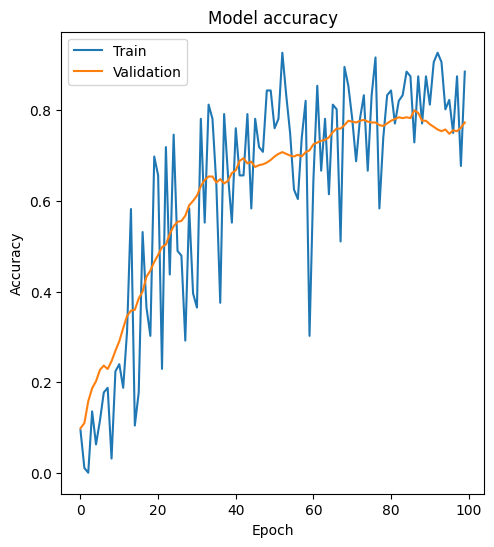

In [134]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_xcept.history['accuracy'])
plt.plot(history_xcept.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

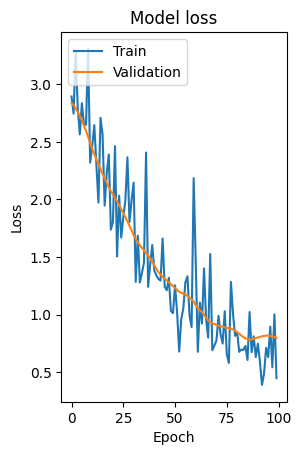

In [135]:
# Plot training & validation loss values

plt.subplot(1, 2, 2)
plt.plot(history_xcept.history['loss'])
plt.plot(history_xcept.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [136]:
# Predict classes with my validation dataset
y_pred = my_xcept_model.predict(validation_generator)
y_pred_classes = y_pred.argmax(axis=-1)

17/17 [==============================] - 12s 625ms/step


Found 520 images belonging to 15 classes.
17/17 [==============================] - 11s 617ms/step
                                precision    recall  f1-score   support

         n02085936-Maltese_dog       0.78      0.71      0.74        45
            n02086240-Shih-Tzu       0.89      0.55      0.68        29
        n02088094-Afghan_hound       0.43      0.95      0.59        39
     n02090721-Irish_wolfhound       1.00      0.14      0.25        35
  n02092002-Scottish_deerhound       0.70      0.89      0.79        37
    n02095889-Sealyham_terrier       0.78      0.86      0.82        36
            n02096051-Airedale       0.97      0.86      0.91        36
     n02097474-Tibetan_terrier       0.77      0.73      0.75        33
n02107683-Bernese_mountain_dog       0.96      0.74      0.83        34
         n02108000-EntleBucher       0.83      0.96      0.89        26
             n02110806-basenji       1.00      0.93      0.96        29
            n02111129-Leonberg       

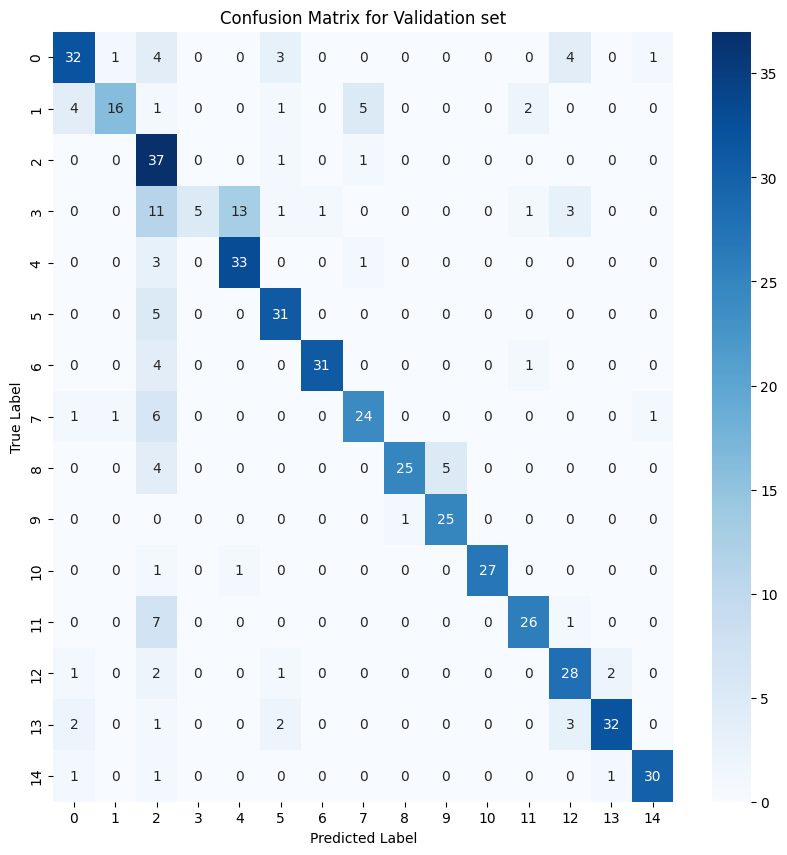

In [137]:
# Recreate the validation generator with shuffle = False

validation_generator = datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,  # Important for correct class labels
)

# Get the true class labels
y_true = validation_generator.classes

# Predict the classes
predictions = my_xcept_model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)

# Get the class indices
class_indices = validation_generator.class_indices

# Create an inverse mapping from index to class name
index_to_class = {v: k for k, v in class_indices.items()}

# Convert true and predicted classes to their respective names
y_true_names = np.vectorize(index_to_class.get)(y_true)
y_pred_names = np.vectorize(index_to_class.get)(y_pred)

# Generate the confusion matrix
cm = confusion_matrix(y_true_names, y_pred_names, labels=list(class_indices.keys()))

# Display the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Validation set')

# Display the classification report
print(classification_report(y_true_names, y_pred_names, target_names=list(class_indices.keys())))


In [138]:
# Predict classes with my validation dataset
predictions_test = my_xcept_model.predict(test_generator)
y_pred_test = np.argmax(predictions_test, axis=1)

11/11 [==============================] - 7s 599ms/step


Found 326 images belonging to 15 classes.
                                precision    recall  f1-score   support

         n02085936-Maltese_dog       0.73      0.76      0.75        25
            n02086240-Shih-Tzu       0.86      0.55      0.67        22
        n02088094-Afghan_hound       0.52      1.00      0.69        24
     n02090721-Irish_wolfhound       1.00      0.14      0.24        22
  n02092002-Scottish_deerhound       0.65      0.87      0.74        23
    n02095889-Sealyham_terrier       0.76      0.95      0.84        20
            n02096051-Airedale       0.89      0.85      0.87        20
     n02097474-Tibetan_terrier       0.71      0.60      0.65        20
n02107683-Bernese_mountain_dog       1.00      0.68      0.81        22
         n02108000-EntleBucher       0.79      0.95      0.86        20
             n02110806-basenji       0.95      1.00      0.98        21
            n02111129-Leonberg       0.76      0.90      0.83        21
      n02111500-Great

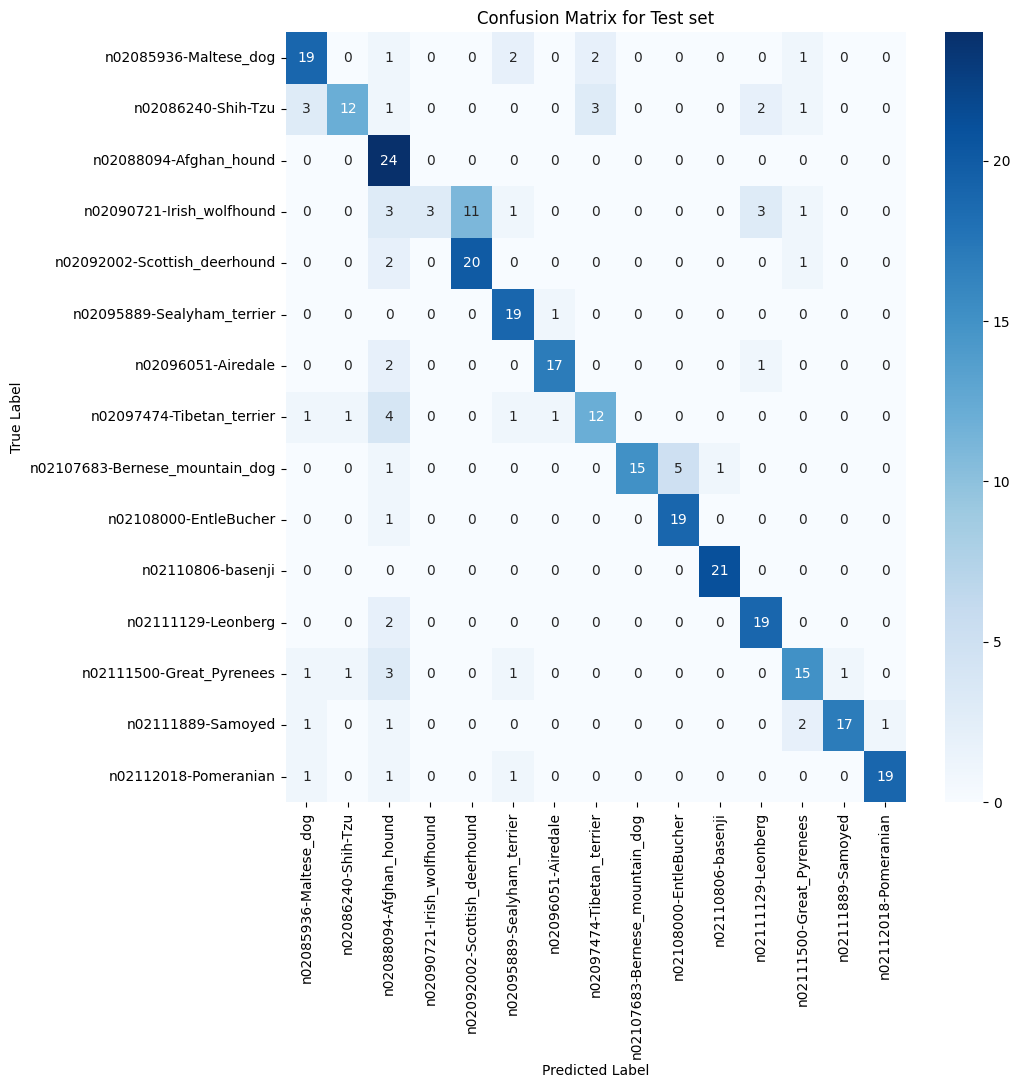

In [139]:
test_generator = datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,  # Important for correct class labels
)

# Get the true class labels
y_true_test = test_generator.classes

# Get breed names
breed_names = list(test_generator.class_indices.keys())

# Create a dictionary to convert class labels to breed names
class_to_breed = {v: k for k, v in test_generator.class_indices.items()}

# Convert class labels to breed names
y_true_test_breeds = [class_to_breed[label] for label in y_true_test]
y_pred_test_breeds = [class_to_breed[label] for label in y_pred_test]

# Generate the confusion matrix
cm_test = confusion_matrix(y_true_test_breeds, y_pred_test_breeds, labels=breed_names)

# Display the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.xticks(ticks=np.arange(len(breed_names)) + 0.5, labels=breed_names, rotation=90)
plt.yticks(ticks=np.arange(len(breed_names)) + 0.5, labels=breed_names, rotation=0)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test set')

# Display the classification report
print(classification_report(y_true_test_breeds, y_pred_test_breeds, target_names=breed_names))


### Sauvegarde du modèle et des indices de classes

In [102]:
# Save the model
my_xcept_model.save('xcept_baselineAdam_lr0_0001_Batch32')

# Save the class_indices
with open('class_indices.json', 'w') as f:
    json.dump(train_generator.class_indices, f)

INFO:tensorflow:Assets written to: xcept_baselineAdam.lr0.001\assets


INFO:tensorflow:Assets written to: xcept_baselineAdam.lr0.001\assets


## Lion model optimiser : lr = 0.001 & batch_size = 32

In [116]:
# Source : https://github.com/google/automl/blob/master/lion/lion_tf2.py
# Upload the file, then place it in your current folder, then import the new Lion optimizer algorithm as 'Lion' to use it. 
# Le module contient l'algorithme que nous testons dans le POC, nous avons donc laissé une copie de l'import ici.

from lion_tf2 import Lion

In [140]:
img_height = 180
img_width = 180
num_channels = 3  # For RGB images

In [141]:
# Load the pre-trained Xception model without the top (classification) layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, num_channels))

In [142]:
# Define directories : # Replace with your cd here when you upload this notebook
train_dir = 'C:\\Users\\Lemel\\OPC-P7\\ProcessedImages\\train'
val_dir = 'C:\\Users\\Lemel\\OPC-P7\\ProcessedImages\\val'
test_dir = 'C:\\Users\\Lemel\\OPC-P7\\ProcessedImages\\test'  

# Initialize the ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)  # normalize pixel values

# Set batch size as per your requirement
batch_size = 32

# Load images from directories
train_generator = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,
)

validation_generator = datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,
)

# Load images from test directory
test_generator = datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,
)

Found 2083 images belonging to 15 classes.
Found 520 images belonging to 15 classes.
Found 326 images belonging to 15 classes.


In [143]:
# Define constants
num_classes = 15  # numbers of breeds here
num_breeds = num_classes  #  num_breeds and num_classes are same

In [144]:
# Define pretrained Xception model
xception_model = tf.keras.applications.xception.Xception(
    weights='imagenet',
    include_top=False, 
    pooling='avg',
    input_shape=(img_height, img_width, num_channels)
)

In [145]:
# Freeze layers of pretrained model
for layer in xception_model.layers:
    layer.trainable = False

In [146]:
# Define new layers
base_output = xception_model.output
base_output = Dense(128, activation='relu')(base_output)
base_output = Dropout(0.2)(base_output)
predictions = Dense(num_breeds, activation='softmax')(base_output)

In [147]:
# Define new model
my_xcept_model = Model(inputs=xception_model.input, outputs=predictions)

# The first learning rate we put here is 0.001 
my_xcept_model.compile(optimizer=Lion(
    lr=0.001,
    beta_1=0.9,
    beta_2=0.99,
    decay=0.0,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    name='Lion',
),
loss='categorical_crossentropy',
metrics=['accuracy']
)

# Define EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)  # adjust patience for 20

In [148]:
# Start timing
start_time = time.time()

# Train the model
history_xcept = my_xcept_model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=len(train_generator) / 32,
    epochs=100,
    verbose=2,
    callbacks=[early_stop] 
)

# End timing and print total training time
end_time = time.time()
total_time = end_time - start_time
print(f"Total training time: {total_time} seconds")

Epoch 1/100
2/2 - 15s - loss: 3.5227 - accuracy: 0.3958 - val_loss: 4.4109 - val_accuracy: 0.0654 - 15s/epoch - 7s/step
Epoch 2/100
2/2 - 12s - loss: 4.8558 - accuracy: 0.0000e+00 - val_loss: 3.1208 - val_accuracy: 0.1558 - 12s/epoch - 6s/step
Epoch 3/100
2/2 - 12s - loss: 2.6134 - accuracy: 0.4688 - val_loss: 3.1459 - val_accuracy: 0.1308 - 12s/epoch - 6s/step
Epoch 4/100
2/2 - 12s - loss: 4.3846 - accuracy: 0.0000e+00 - val_loss: 2.4856 - val_accuracy: 0.2077 - 12s/epoch - 6s/step
Epoch 5/100
2/2 - 13s - loss: 2.6981 - accuracy: 0.0104 - val_loss: 2.3785 - val_accuracy: 0.2885 - 13s/epoch - 6s/step
Epoch 6/100
2/2 - 13s - loss: 2.5764 - accuracy: 0.1250 - val_loss: 2.2607 - val_accuracy: 0.3404 - 13s/epoch - 6s/step
Epoch 7/100
2/2 - 13s - loss: 1.9996 - accuracy: 0.4375 - val_loss: 2.2908 - val_accuracy: 0.2981 - 13s/epoch - 6s/step
Epoch 8/100
2/2 - 13s - loss: 1.7860 - accuracy: 0.5208 - val_loss: 2.3507 - val_accuracy: 0.3038 - 13s/epoch - 6s/step
Epoch 9/100
2/2 - 13s - loss: 1.

In [149]:
# Score sur la validation dataset
score_my_xcept_model = my_xcept_model.evaluate(validation_generator)

17/17 [==============================] - 10s 592ms/step - loss: 0.9682 - accuracy: 0.7385


In [150]:
# Score sur le test dataset
score_my_xcept_model_test = my_xcept_model.evaluate(test_generator)

11/11 [==============================] - 6s 569ms/step - loss: 1.0471 - accuracy: 0.7270


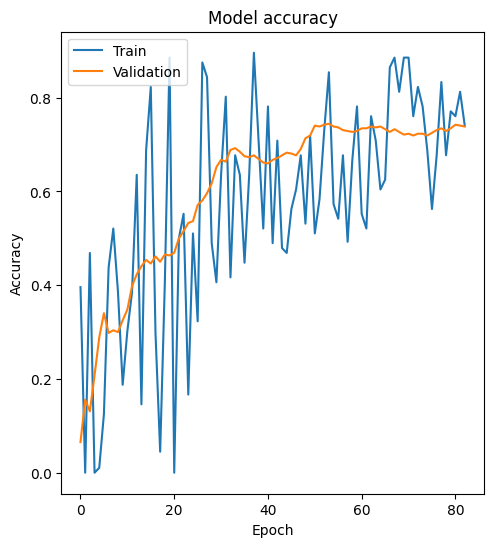

In [151]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_xcept.history['accuracy'])
plt.plot(history_xcept.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

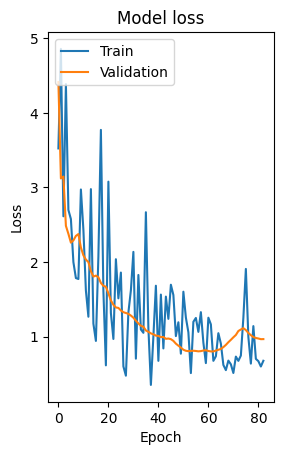

In [152]:
# Plot training & validation loss values

plt.subplot(1, 2, 2)
plt.plot(history_xcept.history['loss'])
plt.plot(history_xcept.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [153]:
# Predict classes with my validation dataset
y_pred = my_xcept_model.predict(validation_generator)
y_pred_classes = y_pred.argmax(axis=-1)

17/17 [==============================] - 11s 599ms/step


Found 520 images belonging to 15 classes.
17/17 [==============================] - 10s 593ms/step
                                precision    recall  f1-score   support

         n02085936-Maltese_dog       0.56      0.84      0.67        45
            n02086240-Shih-Tzu       0.00      0.00      0.00        29
        n02088094-Afghan_hound       0.78      0.79      0.78        39
     n02090721-Irish_wolfhound       0.00      0.00      0.00        35
  n02092002-Scottish_deerhound       0.61      0.84      0.70        37
    n02095889-Sealyham_terrier       0.61      0.92      0.73        36
            n02096051-Airedale       1.00      0.81      0.89        36
     n02097474-Tibetan_terrier       0.53      0.94      0.68        33
n02107683-Bernese_mountain_dog       0.91      0.85      0.88        34
         n02108000-EntleBucher       0.92      0.88      0.90        26
             n02110806-basenji       0.78      0.97      0.86        29
            n02111129-Leonberg       

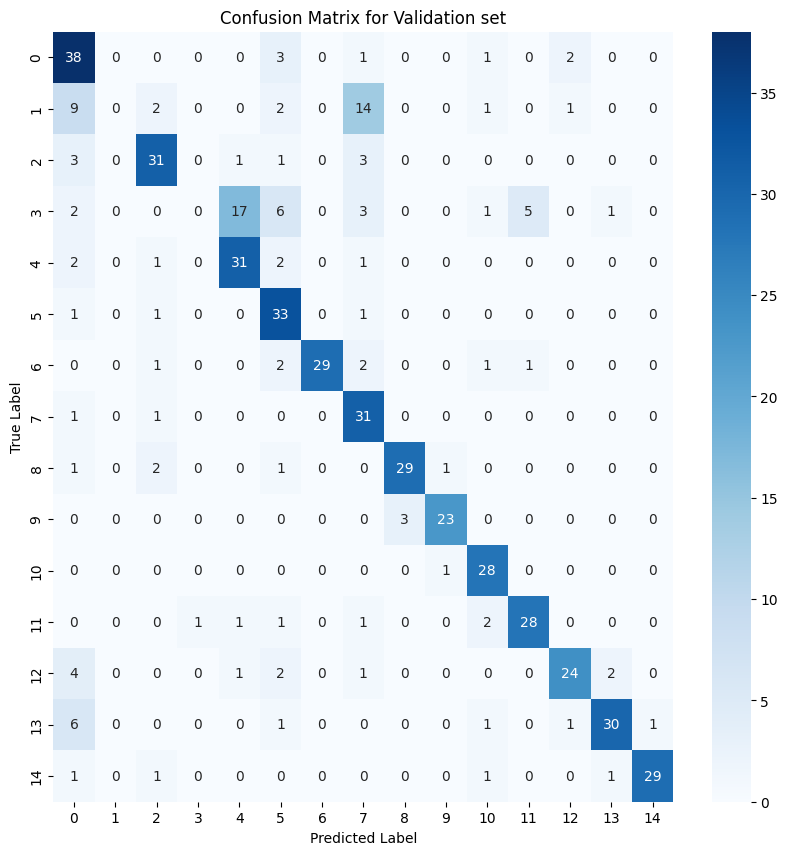

In [154]:
# Recreate the validation generator with shuffle = False

validation_generator = datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,  # Important for correct class labels
)

# Get the true class labels
y_true = validation_generator.classes

# Predict the classes
predictions = my_xcept_model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)

# Get the class indices
class_indices = validation_generator.class_indices

# Create an inverse mapping from index to class name
index_to_class = {v: k for k, v in class_indices.items()}

# Convert true and predicted classes to their respective names
y_true_names = np.vectorize(index_to_class.get)(y_true)
y_pred_names = np.vectorize(index_to_class.get)(y_pred)

# Generate the confusion matrix
cm = confusion_matrix(y_true_names, y_pred_names, labels=list(class_indices.keys()))

# Display the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Validation set')

# Display the classification report
print(classification_report(y_true_names, y_pred_names, target_names=list(class_indices.keys())))


In [155]:
# Predict classes with my validation dataset
predictions_test = my_xcept_model.predict(test_generator)
y_pred_test = np.argmax(predictions_test, axis=1)

11/11 [==============================] - 6s 573ms/step


Found 326 images belonging to 15 classes.
                                precision    recall  f1-score   support

         n02085936-Maltese_dog       0.55      0.84      0.67        25
            n02086240-Shih-Tzu       0.00      0.00      0.00        22
        n02088094-Afghan_hound       0.91      0.88      0.89        24
     n02090721-Irish_wolfhound       0.00      0.00      0.00        22
  n02092002-Scottish_deerhound       0.54      0.87      0.67        23
    n02095889-Sealyham_terrier       0.56      0.95      0.70        20
            n02096051-Airedale       0.94      0.80      0.86        20
     n02097474-Tibetan_terrier       0.49      0.85      0.62        20
n02107683-Bernese_mountain_dog       1.00      0.82      0.90        22
         n02108000-EntleBucher       0.90      0.95      0.93        20
             n02110806-basenji       0.81      1.00      0.89        21
            n02111129-Leonberg       0.71      0.95      0.82        21
      n02111500-Great

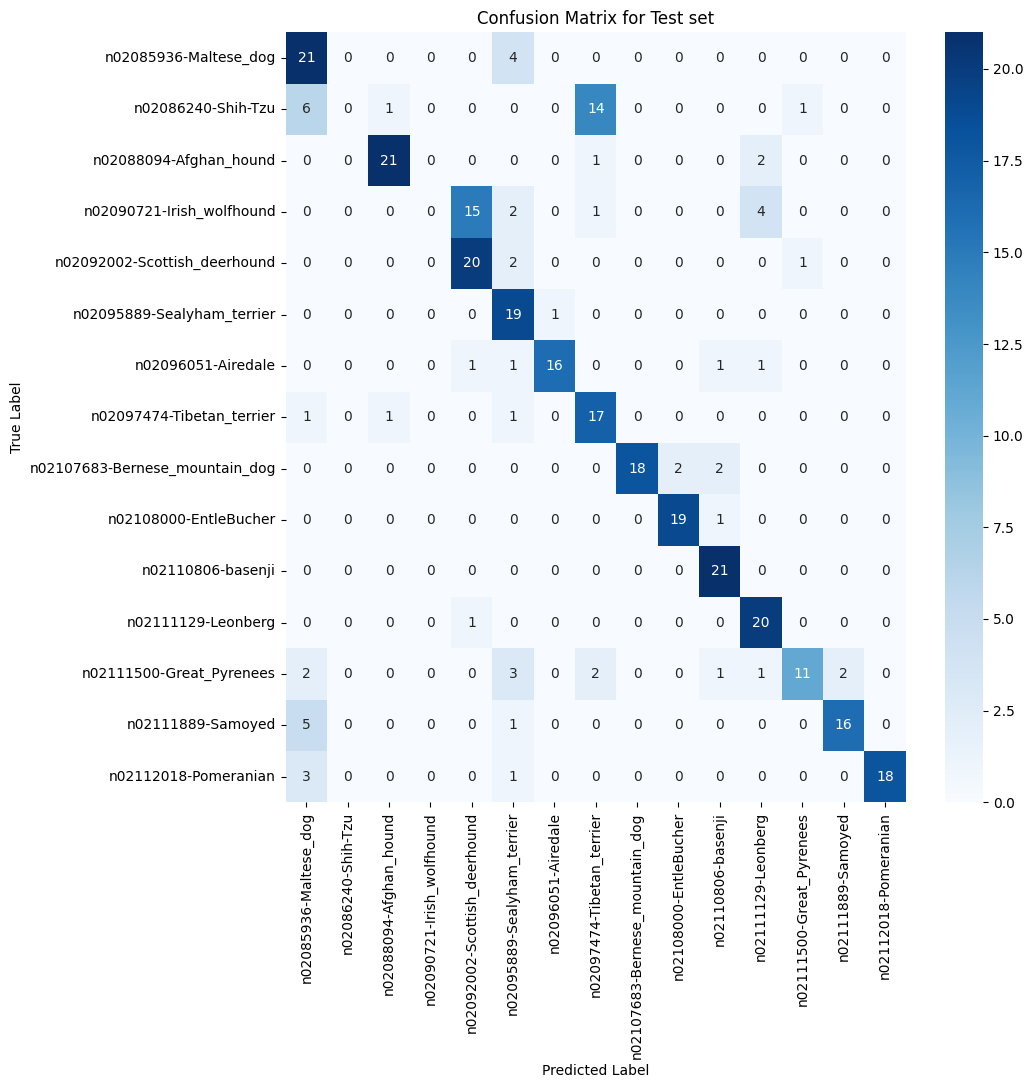

In [156]:
test_generator = datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,  # Important for correct class labels
)

# Get the true class labels
y_true_test = test_generator.classes

# Get breed names
breed_names = list(test_generator.class_indices.keys())

# Create a dictionary to convert class labels to breed names
class_to_breed = {v: k for k, v in test_generator.class_indices.items()}

# Convert class labels to breed names
y_true_test_breeds = [class_to_breed[label] for label in y_true_test]
y_pred_test_breeds = [class_to_breed[label] for label in y_pred_test]

# Generate the confusion matrix
cm_test = confusion_matrix(y_true_test_breeds, y_pred_test_breeds, labels=breed_names)

# Display the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.xticks(ticks=np.arange(len(breed_names)) + 0.5, labels=breed_names, rotation=90)
plt.yticks(ticks=np.arange(len(breed_names)) + 0.5, labels=breed_names, rotation=0)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test set')

# Display the classification report
print(classification_report(y_true_test_breeds, y_pred_test_breeds, target_names=breed_names))


### Sauvegarde du modèle et des indices de classes

In [157]:
# Save the model
my_xcept_model.save('xcept_lion_lr0_001_Batch32')

# Save the class_indices
with open('class_indices.json', 'w') as f:
    json.dump(train_generator.class_indices, f)

INFO:tensorflow:Assets written to: xcept_lion_lr0_001_Batch32\assets


INFO:tensorflow:Assets written to: xcept_lion_lr0_001_Batch32\assets


## Lion model optimiser : lr = 0.0001 & batch_size = 32

In [159]:
img_height = 180
img_width = 180
num_channels = 3  # For RGB images

In [160]:
# Load the pre-trained Xception model without the top (classification) layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, num_channels))

In [161]:
# Define directories : # Replace with your cd here when you upload this notebook
train_dir = 'C:\\Users\\Lemel\\OPC-P7\\ProcessedImages\\train'
val_dir = 'C:\\Users\\Lemel\\OPC-P7\\ProcessedImages\\val'
test_dir = 'C:\\Users\\Lemel\\OPC-P7\\ProcessedImages\\test'  

# Initialize the ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)  # normalize pixel values

# Set batch size as per your requirement
batch_size = 32

# Load images from directories
train_generator = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,
)

validation_generator = datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,
)

# Load images from test directory
test_generator = datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,
)

Found 2083 images belonging to 15 classes.
Found 520 images belonging to 15 classes.
Found 326 images belonging to 15 classes.


In [162]:
# Define constants
num_classes = 15  # numbers of breeds here
num_breeds = num_classes  #  num_breeds and num_classes are same

In [163]:
# Define pretrained Xception model
xception_model = tf.keras.applications.xception.Xception(
    weights='imagenet',
    include_top=False, 
    pooling='avg',
    input_shape=(img_height, img_width, num_channels)
)

In [164]:
# Freeze layers of pretrained model
for layer in xception_model.layers:
    layer.trainable = False

In [165]:
# Define new layers
base_output = xception_model.output
base_output = Dense(128, activation='relu')(base_output)
base_output = Dropout(0.2)(base_output)
predictions = Dense(num_breeds, activation='softmax')(base_output)

In [166]:
# Define new model
my_xcept_model = Model(inputs=xception_model.input, outputs=predictions)

# The first learning rate we put here is 0.0001 
my_xcept_model.compile(optimizer=Lion(
    lr=0.0001,
    beta_1=0.9,
    beta_2=0.99,
    decay=0.0,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    name='Lion',
),
loss='categorical_crossentropy',
metrics=['accuracy']
)

# Define EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)  # adjust patience for 20

In [167]:
# Start timing
start_time = time.time()

# Train the model
history_xcept = my_xcept_model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=len(train_generator) / 32,
    epochs=100,
    verbose=2,
    callbacks=[early_stop] 
)

# End timing and print total training time
end_time = time.time()
total_time = end_time - start_time
print(f"Total training time: {total_time} seconds")

Epoch 1/100
2/2 - 15s - loss: 2.5567 - accuracy: 0.1562 - val_loss: 2.8476 - val_accuracy: 0.0981 - 15s/epoch - 7s/step
Epoch 2/100
2/2 - 12s - loss: 2.8529 - accuracy: 0.0938 - val_loss: 2.8190 - val_accuracy: 0.1250 - 12s/epoch - 6s/step
Epoch 3/100
2/2 - 12s - loss: 2.5132 - accuracy: 0.1979 - val_loss: 2.7807 - val_accuracy: 0.1519 - 12s/epoch - 6s/step
Epoch 4/100
2/2 - 13s - loss: 3.5288 - accuracy: 0.0000e+00 - val_loss: 2.6612 - val_accuracy: 0.1885 - 13s/epoch - 6s/step
Epoch 5/100
2/2 - 13s - loss: 2.2435 - accuracy: 0.3021 - val_loss: 2.5809 - val_accuracy: 0.2327 - 13s/epoch - 6s/step
Epoch 6/100
2/2 - 13s - loss: 3.3303 - accuracy: 0.0312 - val_loss: 2.4505 - val_accuracy: 0.2673 - 13s/epoch - 6s/step
Epoch 7/100
2/2 - 13s - loss: 1.8363 - accuracy: 0.5521 - val_loss: 2.3527 - val_accuracy: 0.3115 - 13s/epoch - 6s/step
Epoch 8/100
2/2 - 13s - loss: 2.4814 - accuracy: 0.3646 - val_loss: 2.2560 - val_accuracy: 0.3519 - 13s/epoch - 6s/step
Epoch 9/100
2/2 - 13s - loss: 2.8890

In [168]:
# Score sur la validation dataset
score_my_xcept_model = my_xcept_model.evaluate(validation_generator)

17/17 [==============================] - 10s 589ms/step - loss: 0.6438 - accuracy: 0.7981


In [169]:
# Score sur le test dataset
score_my_xcept_model_test = my_xcept_model.evaluate(test_generator)

11/11 [==============================] - 6s 573ms/step - loss: 0.5641 - accuracy: 0.8098


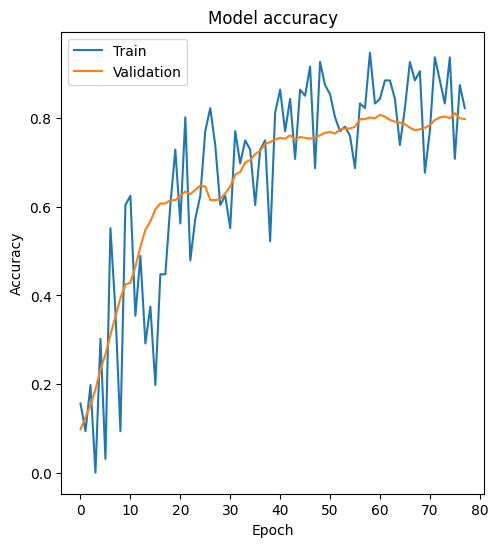

In [170]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_xcept.history['accuracy'])
plt.plot(history_xcept.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

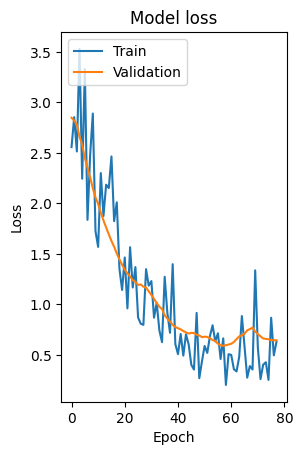

In [171]:
# Plot training & validation loss values

plt.subplot(1, 2, 2)
plt.plot(history_xcept.history['loss'])
plt.plot(history_xcept.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [172]:
# Predict classes with my validation dataset
y_pred = my_xcept_model.predict(validation_generator)
y_pred_classes = y_pred.argmax(axis=-1)

17/17 [==============================] - 11s 591ms/step


Found 520 images belonging to 15 classes.
17/17 [==============================] - 10s 587ms/step
                                precision    recall  f1-score   support

         n02085936-Maltese_dog       0.79      0.73      0.76        45
            n02086240-Shih-Tzu       0.83      0.69      0.75        29
        n02088094-Afghan_hound       0.91      0.77      0.83        39
     n02090721-Irish_wolfhound       0.76      0.63      0.69        35
  n02092002-Scottish_deerhound       0.96      0.65      0.77        37
    n02095889-Sealyham_terrier       0.96      0.75      0.84        36
            n02096051-Airedale       0.85      0.92      0.88        36
     n02097474-Tibetan_terrier       0.77      0.91      0.83        33
n02107683-Bernese_mountain_dog       0.91      0.91      0.91        34
         n02108000-EntleBucher       0.96      0.88      0.92        26
             n02110806-basenji       0.88      0.97      0.92        29
            n02111129-Leonberg       

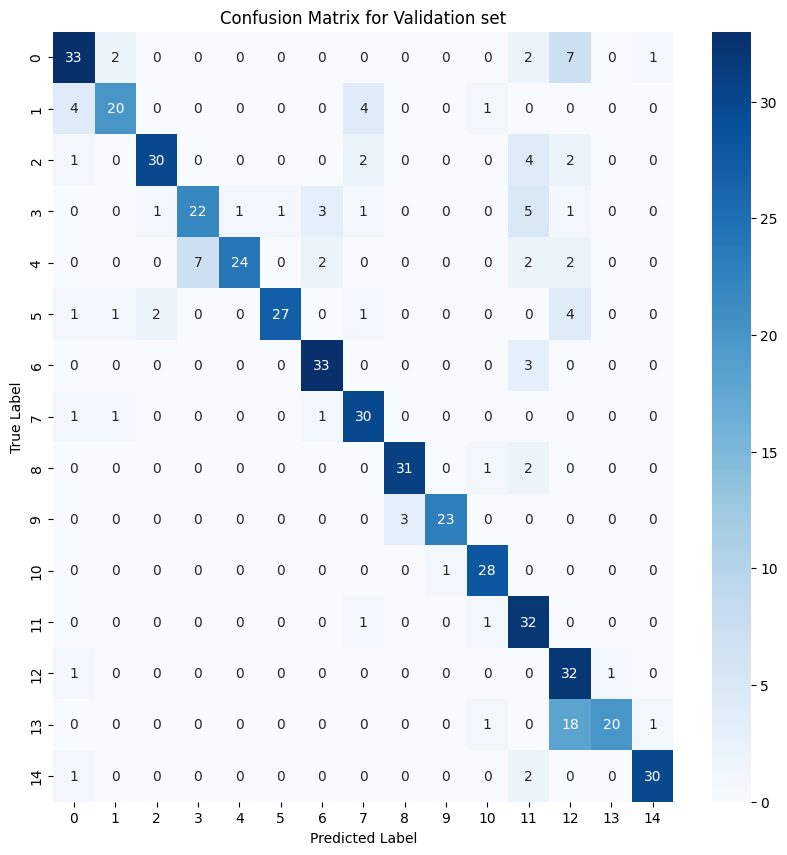

In [173]:
# Recreate the validation generator with shuffle = False

validation_generator = datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,  # Important for correct class labels
)

# Get the true class labels
y_true = validation_generator.classes

# Predict the classes
predictions = my_xcept_model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)

# Get the class indices
class_indices = validation_generator.class_indices

# Create an inverse mapping from index to class name
index_to_class = {v: k for k, v in class_indices.items()}

# Convert true and predicted classes to their respective names
y_true_names = np.vectorize(index_to_class.get)(y_true)
y_pred_names = np.vectorize(index_to_class.get)(y_pred)

# Generate the confusion matrix
cm = confusion_matrix(y_true_names, y_pred_names, labels=list(class_indices.keys()))

# Display the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Validation set')

# Display the classification report
print(classification_report(y_true_names, y_pred_names, target_names=list(class_indices.keys())))


In [174]:
# Predict classes with my validation dataset
predictions_test = my_xcept_model.predict(test_generator)
y_pred_test = np.argmax(predictions_test, axis=1)

11/11 [==============================] - 6s 584ms/step


Found 326 images belonging to 15 classes.
                                precision    recall  f1-score   support

         n02085936-Maltese_dog       0.68      0.76      0.72        25
            n02086240-Shih-Tzu       0.83      0.68      0.75        22
        n02088094-Afghan_hound       0.95      0.88      0.91        24
     n02090721-Irish_wolfhound       0.75      0.55      0.63        22
  n02092002-Scottish_deerhound       0.76      0.70      0.73        23
    n02095889-Sealyham_terrier       0.86      0.90      0.88        20
            n02096051-Airedale       0.90      0.90      0.90        20
     n02097474-Tibetan_terrier       0.75      0.75      0.75        20
n02107683-Bernese_mountain_dog       0.95      0.86      0.90        22
         n02108000-EntleBucher       0.90      0.95      0.93        20
             n02110806-basenji       0.84      1.00      0.91        21
            n02111129-Leonberg       0.70      1.00      0.82        21
      n02111500-Great

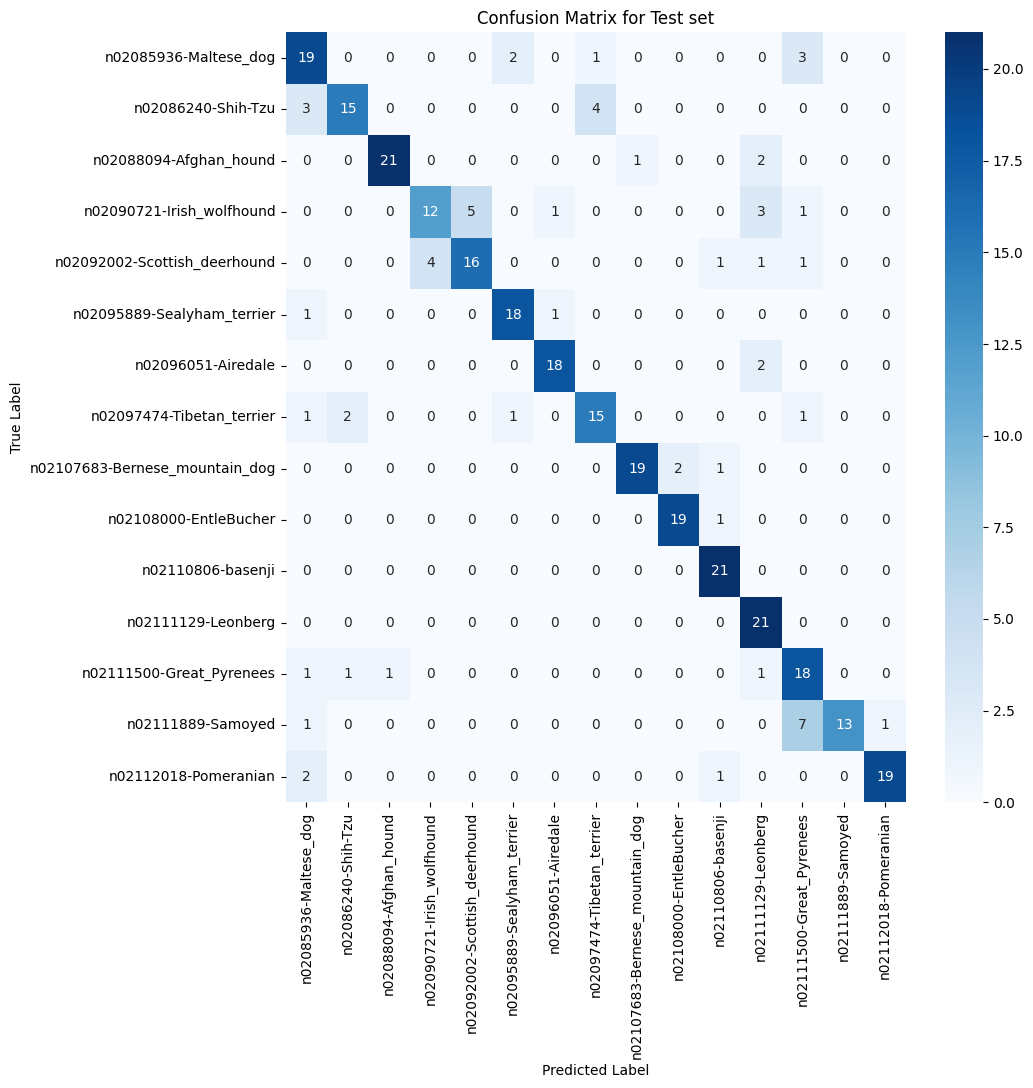

In [175]:
test_generator = datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,  # Important for correct class labels
)

# Get the true class labels
y_true_test = test_generator.classes

# Get breed names
breed_names = list(test_generator.class_indices.keys())

# Create a dictionary to convert class labels to breed names
class_to_breed = {v: k for k, v in test_generator.class_indices.items()}

# Convert class labels to breed names
y_true_test_breeds = [class_to_breed[label] for label in y_true_test]
y_pred_test_breeds = [class_to_breed[label] for label in y_pred_test]

# Generate the confusion matrix
cm_test = confusion_matrix(y_true_test_breeds, y_pred_test_breeds, labels=breed_names)

# Display the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.xticks(ticks=np.arange(len(breed_names)) + 0.5, labels=breed_names, rotation=90)
plt.yticks(ticks=np.arange(len(breed_names)) + 0.5, labels=breed_names, rotation=0)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test set')

# Display the classification report
print(classification_report(y_true_test_breeds, y_pred_test_breeds, target_names=breed_names))


### Sauvegarde du modèle et des indices de classes

In [176]:
# Save the model
my_xcept_model.save('xcept_lion_lr0_0001_Batch32')

# Save the class_indices
with open('class_indices.json', 'w') as f:
    json.dump(train_generator.class_indices, f)

INFO:tensorflow:Assets written to: xcept_lion_lr0_0001_Batch32\assets


INFO:tensorflow:Assets written to: xcept_lion_lr0_0001_Batch32\assets


## Lion model optimiser : lr = 0.0001 & batch_size = 128

In [177]:
img_height = 180
img_width = 180
num_channels = 3  # For RGB images

In [178]:
# Load the pre-trained Xception model without the top (classification) layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(img_height, img_width, num_channels))

In [179]:
# Define directories : # Replace with your cd here when you upload this notebook
train_dir = 'C:\\Users\\Lemel\\OPC-P7\\ProcessedImages\\train'
val_dir = 'C:\\Users\\Lemel\\OPC-P7\\ProcessedImages\\val'
test_dir = 'C:\\Users\\Lemel\\OPC-P7\\ProcessedImages\\test'  

# Initialize the ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)  # normalize pixel values

# Set batch size as per your requirement
batch_size = 128

# Load images from directories
train_generator = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,
)

validation_generator = datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,
)

# Load images from test directory
test_generator = datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,
)

Found 2083 images belonging to 15 classes.
Found 520 images belonging to 15 classes.
Found 326 images belonging to 15 classes.


In [180]:
# Define constants
num_classes = 15  # numbers of breeds here
num_breeds = num_classes  #  num_breeds and num_classes are same

In [181]:
# Define pretrained Xception model
xception_model = tf.keras.applications.xception.Xception(
    weights='imagenet',
    include_top=False, 
    pooling='avg',
    input_shape=(img_height, img_width, num_channels)
)

In [182]:
# Freeze layers of pretrained model
for layer in xception_model.layers:
    layer.trainable = False

In [183]:
# Define new layers
base_output = xception_model.output
base_output = Dense(128, activation='relu')(base_output)
base_output = Dropout(0.2)(base_output)
predictions = Dense(num_breeds, activation='softmax')(base_output)

In [184]:
# Define new model
my_xcept_model = Model(inputs=xception_model.input, outputs=predictions)

# The first learning rate we put here is 0.0001 
my_xcept_model.compile(optimizer=Lion(
    lr=0.0001,
    beta_1=0.9,
    beta_2=0.99,
    decay=0.0,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    name='Lion',
),
loss='categorical_crossentropy',
metrics=['accuracy']
)

# Define EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)  # adjust patience for 20

In [189]:
# Start timing
start_time = time.time()

# Train the model
history_xcept = my_xcept_model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=len(train_generator) * 0.25,  # Scaled by the factor 0.25 (32/128),
    epochs=100,
    verbose=2,
    callbacks=[early_stop] 
)

# End timing and print total training time
end_time = time.time()
total_time = end_time - start_time
print(f"Total training time: {total_time} seconds")

Epoch 1/100
4/4 - 20s - loss: 1.5784 - accuracy: 0.7112 - val_loss: 1.4510 - val_accuracy: 0.7462 - 20s/epoch - 5s/step
Epoch 2/100
4/4 - 22s - loss: 1.3786 - accuracy: 0.6953 - val_loss: 1.3171 - val_accuracy: 0.7462 - 22s/epoch - 5s/step
Epoch 3/100
4/4 - 24s - loss: 1.3758 - accuracy: 0.6953 - val_loss: 1.1925 - val_accuracy: 0.7519 - 24s/epoch - 6s/step
Epoch 4/100
4/4 - 22s - loss: 1.2486 - accuracy: 0.6801 - val_loss: 1.0863 - val_accuracy: 0.7615 - 22s/epoch - 5s/step
Epoch 5/100
4/4 - 24s - loss: 1.0162 - accuracy: 0.7703 - val_loss: 0.9839 - val_accuracy: 0.7788 - 24s/epoch - 6s/step
Epoch 6/100
4/4 - 24s - loss: 1.0899 - accuracy: 0.6984 - val_loss: 0.8919 - val_accuracy: 0.7846 - 24s/epoch - 6s/step
Epoch 7/100
4/4 - 21s - loss: 0.7182 - accuracy: 0.8007 - val_loss: 0.8142 - val_accuracy: 0.7865 - 21s/epoch - 5s/step
Epoch 8/100
4/4 - 23s - loss: 0.6801 - accuracy: 0.8297 - val_loss: 0.7503 - val_accuracy: 0.7885 - 23s/epoch - 5s/step
Epoch 9/100
4/4 - 24s - loss: 0.7492 - a

In [190]:
# Score sur la validation dataset
score_my_xcept_model = my_xcept_model.evaluate(validation_generator)

5/5 [==============================] - 10s 2s/step - loss: 0.5404 - accuracy: 0.8346


In [191]:
# Score sur le test dataset
score_my_xcept_model_test = my_xcept_model.evaluate(test_generator)

3/3 [==============================] - 6s 2s/step - loss: 0.5814 - accuracy: 0.8190


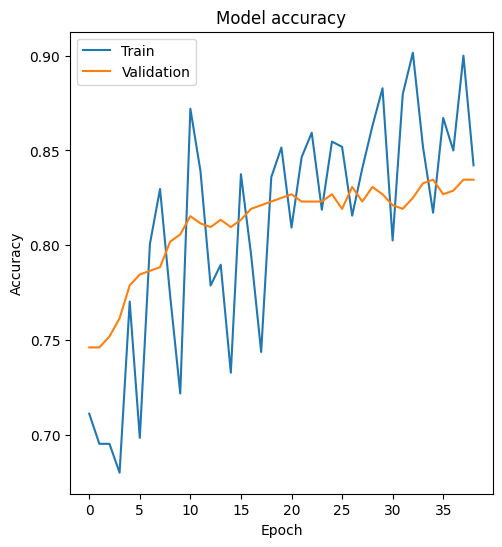

In [192]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_xcept.history['accuracy'])
plt.plot(history_xcept.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

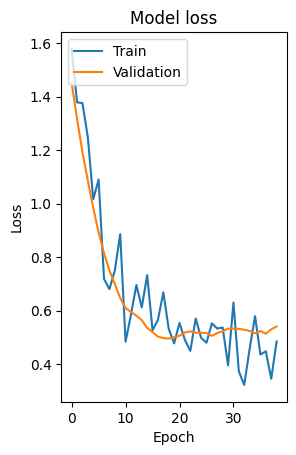

In [193]:
# Plot training & validation loss values

plt.subplot(1, 2, 2)
plt.plot(history_xcept.history['loss'])
plt.plot(history_xcept.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [194]:
# Predict classes with my validation dataset
y_pred = my_xcept_model.predict(validation_generator)
y_pred_classes = y_pred.argmax(axis=-1)

5/5 [==============================] - 10s 2s/step


Found 520 images belonging to 15 classes.
5/5 [==============================] - 10s 2s/step
                                precision    recall  f1-score   support

         n02085936-Maltese_dog       0.78      0.71      0.74        45
            n02086240-Shih-Tzu       0.70      0.79      0.74        29
        n02088094-Afghan_hound       0.78      0.79      0.78        39
     n02090721-Irish_wolfhound       0.63      0.91      0.74        35
  n02092002-Scottish_deerhound       1.00      0.57      0.72        37
    n02095889-Sealyham_terrier       0.94      0.83      0.88        36
            n02096051-Airedale       1.00      0.89      0.94        36
     n02097474-Tibetan_terrier       0.85      0.85      0.85        33
n02107683-Bernese_mountain_dog       0.94      0.88      0.91        34
         n02108000-EntleBucher       0.86      0.92      0.89        26
             n02110806-basenji       0.84      0.90      0.87        29
            n02111129-Leonberg       0.84 

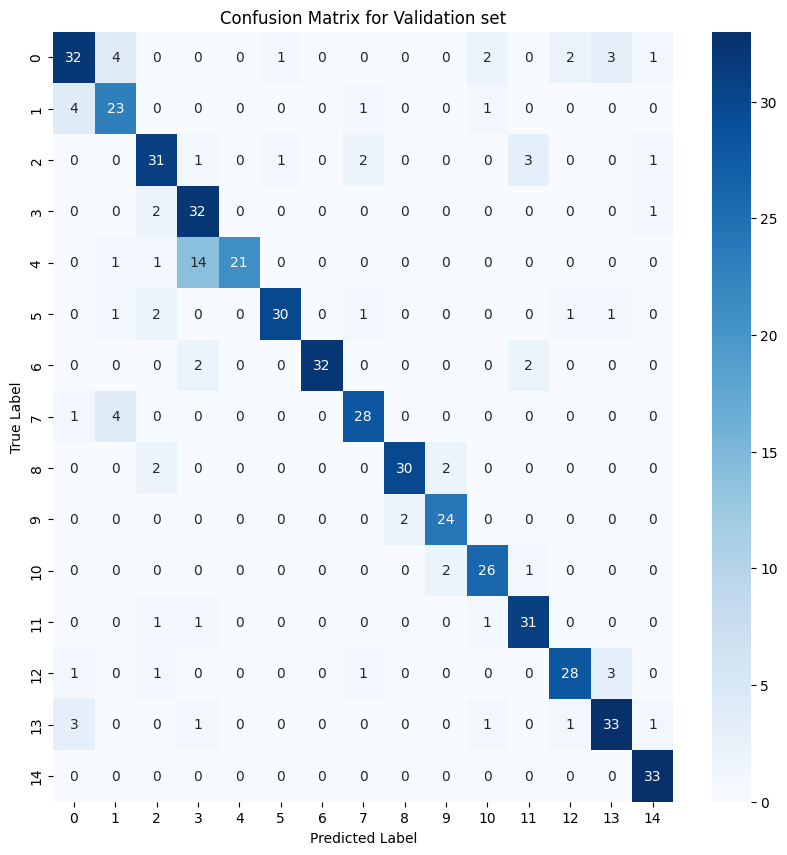

In [195]:
# Recreate the validation generator with shuffle = False

validation_generator = datagen.flow_from_directory(
    directory=val_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,  # Important for correct class labels
)

# Get the true class labels
y_true = validation_generator.classes

# Predict the classes
predictions = my_xcept_model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)

# Get the class indices
class_indices = validation_generator.class_indices

# Create an inverse mapping from index to class name
index_to_class = {v: k for k, v in class_indices.items()}

# Convert true and predicted classes to their respective names
y_true_names = np.vectorize(index_to_class.get)(y_true)
y_pred_names = np.vectorize(index_to_class.get)(y_pred)

# Generate the confusion matrix
cm = confusion_matrix(y_true_names, y_pred_names, labels=list(class_indices.keys()))

# Display the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Validation set')

# Display the classification report
print(classification_report(y_true_names, y_pred_names, target_names=list(class_indices.keys())))


In [196]:
# Predict classes with my validation dataset
predictions_test = my_xcept_model.predict(test_generator)
y_pred_test = np.argmax(predictions_test, axis=1)

3/3 [==============================] - 6s 2s/step


Found 326 images belonging to 15 classes.
                                precision    recall  f1-score   support

         n02085936-Maltese_dog       0.83      0.80      0.82        25
            n02086240-Shih-Tzu       0.76      0.73      0.74        22
        n02088094-Afghan_hound       0.92      0.96      0.94        24
     n02090721-Irish_wolfhound       0.48      0.68      0.57        22
  n02092002-Scottish_deerhound       0.67      0.43      0.53        23
    n02095889-Sealyham_terrier       0.90      0.95      0.93        20
            n02096051-Airedale       0.94      0.80      0.86        20
     n02097474-Tibetan_terrier       0.76      0.80      0.78        20
n02107683-Bernese_mountain_dog       0.90      0.86      0.88        22
         n02108000-EntleBucher       0.86      0.95      0.90        20
             n02110806-basenji       0.91      0.95      0.93        21
            n02111129-Leonberg       0.75      1.00      0.86        21
      n02111500-Great

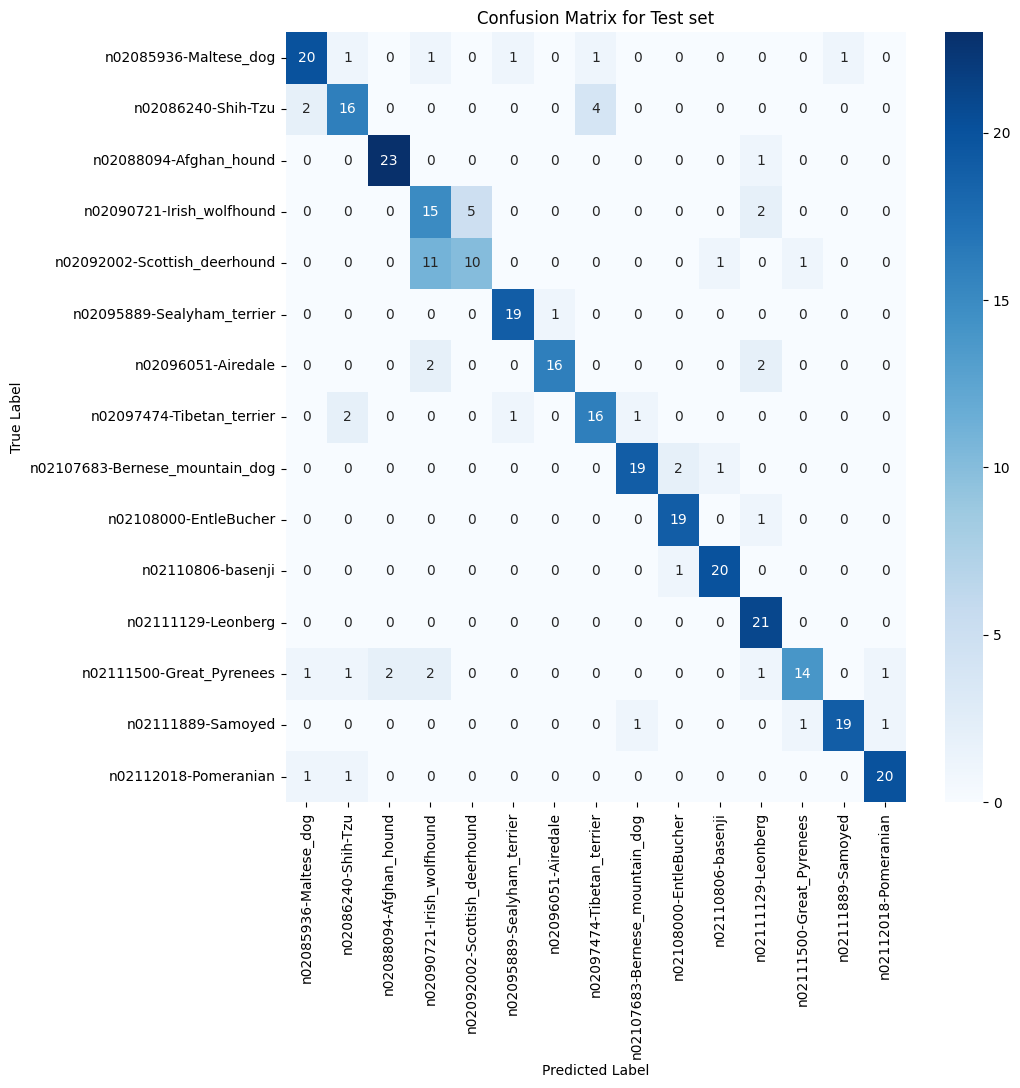

In [197]:
test_generator = datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,  # Important for correct class labels
)

# Get the true class labels
y_true_test = test_generator.classes

# Get breed names
breed_names = list(test_generator.class_indices.keys())

# Create a dictionary to convert class labels to breed names
class_to_breed = {v: k for k, v in test_generator.class_indices.items()}

# Convert class labels to breed names
y_true_test_breeds = [class_to_breed[label] for label in y_true_test]
y_pred_test_breeds = [class_to_breed[label] for label in y_pred_test]

# Generate the confusion matrix
cm_test = confusion_matrix(y_true_test_breeds, y_pred_test_breeds, labels=breed_names)

# Display the confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.xticks(ticks=np.arange(len(breed_names)) + 0.5, labels=breed_names, rotation=90)
plt.yticks(ticks=np.arange(len(breed_names)) + 0.5, labels=breed_names, rotation=0)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test set')

# Display the classification report
print(classification_report(y_true_test_breeds, y_pred_test_breeds, target_names=breed_names))


### Sauvegarde du modèle et des indices de classes

In [198]:
# Save the model
my_xcept_model.save('xcept_lion_lr0_0001_Batch128')

# Save the class_indices
with open('class_indices.json', 'w') as f:
    json.dump(train_generator.class_indices, f)

INFO:tensorflow:Assets written to: xcept_lion_lr0_0001_Batch128\assets


INFO:tensorflow:Assets written to: xcept_lion_lr0_0001_Batch128\assets
